In [1]:
# For Development and debugging:
# Reload modul without restarting the kernel
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
pd.options.display.max_columns = None
import os
import sys
import matplotlib.pyplot as plt
import json
import copy
import seaborn as sns
sns.set_theme(style="darkgrid")

# Add EXTERNAL_LIBS_PATH to sys paths (for loading libraries)
EXTERNAL_LIBS_PATH = '/home/hhughes/Documents/Master_Thesis/Project/workspace/libs'
sys.path.insert(1, EXTERNAL_LIBS_PATH)

# Load cortum libs
import NN_interpretability as nn_inter
import Data_augmentation as data_aug
import tfds_utils

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [3]:
# Set parameters
params = {}
params['base_path'] = '/home/hhughes/Documents/Master_Thesis/Project/workspace/Interpretability'
params['model_dirs'] = {
    'BL_RIV2_test4': '/home/hhughes/Documents/Master_Thesis/Project/workspace/Interpretability/Models/BL_RIV2_test4',}
params['CMA'] = 'CMA_0'
params['cells'] = ['258520', '208516', '262920', '307720']
params['tf_ds_name'] = 'mpp_ds_normal_dmso_z_score'
params['local_tf_datasets'] = '/data/Master_Thesis_data/datasets/tensorflow_datasets'
params['score_maps_path'] = '/data/Master_Thesis_data/datasets/Score_Maps/VarGrad_IG/BL_RIV2_test4'

plot_dir = os.path.join(params['base_path'], 'Plots')
os.makedirs(plot_dir, exist_ok=True)

# Notas
- BL_t8 mide 08_H3K4ME3 usando 09_SRRM2
- It looks like cell 277420 is 2 overlaped cells.

## 1.1.- Load dataset

In [4]:
# Path where tf datasets are
dataset, ds_info = tfds.load(
    name=params['tf_ds_name'], 
    data_dir=params['local_tf_datasets'], 
    # If False, returns a dictionary with all the features
    as_supervised=False, 
    shuffle_files=False,
    with_info=True)

# Load TFDS metadata
tfds_metadata = tfds_utils.Costum_TFDS_metadata().load_metadata(ds_info.data_dir)
tfds_metadata.keys()

# Load splits
train_data, val_data = dataset['train'], dataset['validation']

In [5]:
ds_info.splits

{'test': <tfds.core.SplitInfo num_examples=371>,
 'train': <tfds.core.SplitInfo num_examples=2962>,
 'validation': <tfds.core.SplitInfo num_examples=370>}

In [6]:
ds_info.features

FeaturesDict({
    'image': Tensor(shape=(224, 224, 38), dtype=tf.float32),
    'mapobject_id_cell': Text(shape=(), dtype=tf.string),
    'target': Tensor(shape=(1,), dtype=tf.float64),
})

In [7]:
tfds_metadata['metadata_df']

mapobject_id_cell  mapobject_id plate_name well_name  well_pos_y  \
0                263042        263055    plate01       J16           0   
1                263043        263056    plate01       J16           0   
2                263044        263057    plate01       J16           0   
3                263045        263058    plate01       J16           0   
4                263047        263060    plate01       J16           0   
...                 ...           ...        ...       ...         ...   
3698             266516        266565    plate01       J12           5   
3699             266518        266567    plate01       J12           5   
3700             266519        266568    plate01       J12           5   
3701             266520        266569    plate01       J12           5   
3702             266521        266570    plate01       J12           5   

      well_pos_x  tpoint  zplane  label  is_border plate_name_cell  \
0              0       0       0      4          0         plate01   
1              0       0       0      5          0         plate01   
2              0       0       0      6          0         plate01   
3              0       0       0      7          0         plate01   
4              0       0       0      9          0         plate01   
...          ...     ...     ...    ...        ...             ...   
3698           4       0       0     44          0         plate01   
3699           4       0       0     46          0         plate01   
3700           4       0       0     47          0         plate01   
3701           4       0       0     48          0         plate01   
3702           4       0       0     49          0         plate01   

     well_name_cell  well_pos_y_cell  well_pos_x_cell  tpoint_cell  \
0               J16                0                0            0   
1               J16                0                0            0   
2               J16                0                0            0   
3               J16                0                0            0   
4               J16                0                0            0   
...             ...              ...              ...          ...   
3698            J12                5                4            0   
3699            J12                5                4            0   
3700            J12                5                4            0   
3701            J12                5                4            0   
3702            J12                5                4            0   

      zplane_cell  label_cell  is_border_cell  is_mitotic  is_mitotic_labels  \
0               0           4               0         0.0                NaN   
1               0           5               0         0.0                NaN   
2               0           6               0         0.0                NaN   
3               0           7               0         0.0                NaN   
4               0           9               0         0.0                NaN   
...           ...         ...             ...         ...                ...   
3698            0          44               0         0.0                NaN   
3699            0          46               0         0.0                NaN   
3700            0          47               0         0.0                NaN   
3701            0          48               0         0.0                NaN   
3702            0          49               0         0.0                NaN   

      is_polynuclei_HeLa  is_polynuclei_HeLa_labels  is_polynuclei_184A1  \
0                    0.0                        NaN                  0.0   
1                    0.0                        NaN                  0.0   
2                    0.0                        NaN                  0.0   
3                    0.0                        NaN                  0.0   
4                    0.0                        NaN                  0.0   
...               

In [8]:
# take a look into the bigger cels also
big_cells = tfds_metadata['metadata_df'].sort_values(by='cell_size_ratio', ascending=False).head(21)[['mapobject_id_cell']]
big_cells = big_cells.values.reshape(-1).astype('str')

In [9]:
channels_df = tfds_metadata['channels_df']
channel_names = [c.split("_")[1:] for c in channels_df.name.values]
channel_names = ["_".join(c) for c in channel_names]
channels_df['channel_name'] = channel_names
channels_df

original_channel_id               name  train_98_percentile  \
0                   0.0            00_DAPI            69.300003   
1                   1.0             07_H2B           310.299988   
2                   2.0      01_CDK9_pT186            46.889076   
3                   3.0            03_CDK9            90.797798   
4                   4.0           05_GTF2B           188.166107   
5                   5.0          07_SETD1A            91.989853   
6                   6.0         08_H3K4me3           105.921074   
7                   7.0           09_SRRM2           273.374664   
8                   8.0         10_H3K27ac           175.104874   
9                   9.0       11_KPNA2_MAX           115.093430   
10                 10.0  12_RB1_pS807_S811           183.208527   
11                 11.0          13_PABPN1           396.026215   
12                 12.0            14_PCNA           146.451843   
13                 13.0             15_SON           243.390030   
14                 14.0              16_H3           439.498047   
15                 15.0           17_HDAC3           145.043106   
16                 16.0       19_KPNA1_MAX           146.208435   
17                 17.0           20_SP100           219.365936   
18                 18.0             21_NCL           201.973480   
19                 19.0          01_PABPC1            50.292484   
20                 20.0            02_CDK7           277.580566   
21                 21.0            03_RPS6            44.969013   
22                 22.0              05_Sm           104.192703   
23                 23.0          07_POLR2A           323.886353   
24                 24.0           09_CCNT1           201.454315   
25                 25.0      10_POL2RA_pS2           541.873108   
26                 26.0             11_PML            81.143768   
27                 27.0            12_YAP1           195.926712   
28                 28.0      13_POL2RA_pS5           445.722107   
29                 29.0        15_U2SNRNPB            85.901764   
30                 30.0            18_NONO           589.345154   
31                 31.0          20_ALYREF           652.734131   
32                 32.0            21_COIL            24.306330   
33                 33.0           00_BG488            16.733833   
34                 34.0           00_BG568             8.009804   
35                 36.0   09_SRRM2_ILASTIK         55576.000000   
36                 37.0     15_SON_ILASTIK         56925.000000   
37                  NaN          cell_mask                  NaN   
38                 35.0              00_EU                  NaN   

    train_mean_after_clipping  train_stddev_after_clipping    type  \
0                   29.277029                    14.289816   input   
1                  128.472672                    67.600372   input   
2                   10.841645                    10.662010   input   
3                   24.890778                    20.744143   input   
4                   76.841652                    45.399426   input   
5                   20.670820                    20.641857   input   
6                   34.419682                    24.227314   input   
7                   39.124294                    58.492748   input   
8                   59.614319                    42.007408   input   
9                   41.293499                    23.342470   input   
10                  65.255531                    49.110687   input   
11                 138.612808                    91.138077   input   
12                  44.440742                    31.906260   input   
13                  32.512615                    51.612625   input   
14                 180.586700                    91.283607   input   
15                  57.925873                    27.662651   input   
16                  59.349533                    29.676619   input   
17                  12.757618                    36.084538   in

In [10]:
# Load model parameters
temp_key = list(params['model_dirs'].keys())[0]
temp_path = os.path.join(params['model_dirs'][temp_key], 'parameters.json')
with open(temp_path, 'r') as file:
    model_params = json.load(file)
print(model_params.keys())

dict_keys(['parameters_file_path', 'external_libs_path', 'model_name', 'custom_model_class', 'pre_training', 'dense_reg', 'conv_reg', 'bias_l2_reg', 'number_of_epochs', 'early_stop_patience', 'loss', 'learning_rate', 'BATCH_SIZE', 'verbose_level', 'model_path', 'basename', 'base_path', 'clean_model_dir', 'tf_ds_name', 'input_channels', 'shuffle_files', 'local_tf_datasets', 'random_horizontal_flipping', 'random_90deg_rotations', 'CenterZoom', 'CenterZoom_mode', 'Random_channel_intencity', 'RCI_dist', 'RCI_mean', 'RCI_stddev', 'RCI_rescale_cte', 'log_path', 'log_file', 'tensorboard', 'seed', 'disable_gpu', 'set_memory_growth', 'cell_size_ratio_mean', 'cell_size_ratio_stddev', 'cell_size_ratio_low_bound'])


In [11]:
# Get input_ids
selected_channels = model_params['input_channels']
n_channels = len(selected_channels)
input_ids = np.array(channels_df.set_index(['name']).loc[selected_channels].TFDS_channel_id.values)
input_ids = np.sort(input_ids.astype(np.int16))
input_channel_names = channels_df.sort_values(by='TFDS_channel_id').set_index('TFDS_channel_id').loc[range(n_channels)].name.values
msg = 'Input channel ids:\n{}'.format(input_ids)
print(msg)

Input channel ids:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32]


## 1.2.- Load Model Data

In [12]:
#models_path = os.path.join(params['base_path'], 'Models', params['model_dir'])
targets_df = pd.DataFrame()
for i, model in enumerate(params['model_dirs'].keys()):
    model_dir = params['model_dirs'][model]
    print('Reading predicted values for model: ', model)
    temp_path = os.path.join(model_dir, 'targets_'+params['CMA']+'.csv')
    with open(temp_path, 'r') as file:
        temp_df = pd.read_csv(file)
    temp_df = temp_df.drop(['y - y_hat'], axis=1)
    prediction_name = 'y_hat'+'_'+model
    temp_df[prediction_name] = temp_df.y_hat
    temp_df = temp_df.drop(['y_hat'], axis=1)
    if i == 0:
        targets_df = temp_df.copy()
    else:
        temp_df = temp_df[['mapobject_id_cell', prediction_name]]
        targets_df = targets_df.merge(temp_df, 
                                      left_on='mapobject_id_cell',
                                      right_on='mapobject_id_cell',
                                      how='left')
targets_df.mapobject_id_cell = targets_df.mapobject_id_cell.astype('string')
mask = targets_df.mapobject_id_cell.isin(np.array(params['cells']))
round(targets_df[mask], 2)

Reading predicted values for model:  BL_RIV2_test4


y mapobject_id_cell    set perturbation cell_cycle  \
18    169.75            258520  train       normal         G1   
2934  513.50            262920  train       normal         G2   
3129  400.17            208516    val       normal          S   
3133  366.16            307720    val         DMSO         G1   

      y_hat_BL_RIV2_test4  
18                 280.56  
2934               497.50  
3129               418.22  
3133               331.48

In [13]:
# Devide cell in Low TR medium and High
#low_per = targets_df.y.quantile(0.2)
#high_per = targets_df.y.quantile(0.8)
#print(low_per, high_per)
y_std = targets_df.y.std()
y_mean = targets_df.y.mean()
print(y_mean, y_std)
low_per = y_mean-y_std
high_per = y_mean+y_std
print(low_per, high_per)

mask_low = targets_df.y <= low_per
n_low = np.sum((mask_low).values)
mask_avg = (targets_df.y > low_per) & (targets_df.y < high_per)
n_avg = np.sum((mask_avg).values)
mask_high = targets_df.y >= high_per
n_high = np.sum((mask_high).values)
print(n_low, n_avg, n_high)
n_samples = n_low + n_avg + n_high
print(n_low/n_samples, n_avg/n_samples, n_high/n_samples)

# Save TR level
targets_df['TR_Level'] = 'Avg_TR'
temp_idxs = targets_df[mask_low].index
targets_df.loc[temp_idxs, 'TR_Level'] = 'Low_TR'
temp_idxs = targets_df[mask_high].index
targets_df.loc[temp_idxs, 'TR_Level'] = 'High_TR'
targets_df

377.2833369803886 60.71855957335795
316.56477740703065 438.0018965537465
532 2626 545
0.14366729678638943 0.7091547394004861 0.1471779638131245


y mapobject_id_cell    set perturbation cell_cycle  \
0     337.603180            305670  train         DMSO         G1   
1     436.179108            248989  train         DMSO         G1   
2     344.612427            212764  train       normal         G1   
3     397.731262            383254  train       normal         G1   
4     251.880371            287059  train         DMSO         G1   
...          ...               ...    ...          ...        ...   
3698  400.196350            321028   test       normal         G1   
3699  414.214355            194787   test       normal          S   
3700  354.966553            259718   test       normal         G1   
3701  425.607788            351947   test       normal         G1   
3702  452.497894            224150   test       normal         G1   

      y_hat_BL_RIV2_test4 TR_Level  
0              393.687317   Avg_TR  
1              432.883423   Avg_TR  
2              340.201813   Avg_TR  
3              351.875275   Avg_TR  
4              375.951721   Low_TR  
...                   ...      ...  
3698           418.039886   Avg_TR  
3699           404.132172   Avg_TR  
3700           350.943604   Avg_TR  
3701           344.580719   Avg_TR  
3702           471.355652  High_TR  

[3703 rows x 7 columns]

In [14]:
# Select cells to plot
#temp_df = targets_df.copy()
#temp_df['y - y_hat_BL'] = (temp_df.y - temp_df.y_hat_BL).abs()
#mask = (temp_df.y < high_per) & (temp_df.y > low_per)
#temp_df[mask].sort_values('y - y_hat_BL').head(50)

## 1.3.- Load score maps info

In [15]:
# load score maps metadata
score_maps_dir = os.path.join(params['score_maps_path'], 'data')
temp_path = os.path.join(params['score_maps_path'], 'score_map_stddev.csv')
score_map_stddev = pd.read_csv(temp_path)
score_map_stddev.mapobject_id_cell = score_map_stddev.mapobject_id_cell.astype('string')
# Add more info
score_map_stddev = score_map_stddev.merge(targets_df,
                                          left_on='mapobject_id_cell',
                                          right_on='mapobject_id_cell',
                                          how='left')
score_map_stddev

00_DAPI    07_H2B  01_CDK9_pT186   03_CDK9  05_GTF2B  07_SETD1A  \
0     0.021712  0.026482       0.034386  0.023784  0.045908   0.049194   
1     0.020170  0.035940       0.050272  0.034937  0.049571   0.042441   
2     0.018793  0.026389       0.027446  0.024622  0.054141   0.034503   
3     0.018321  0.023612       0.025744  0.026229  0.053796   0.034834   
4     0.023292  0.033220       0.032970  0.025329  0.039393   0.038383   
...        ...       ...            ...       ...       ...        ...   
3327  0.019426  0.030366       0.022787  0.023246  0.049333   0.034073   
3328  0.017834  0.028148       0.025597  0.025700  0.053045   0.032745   
3329  0.021248  0.027665       0.035129  0.024183  0.048275   0.036643   
3330  0.024374  0.032586       0.028637  0.021495  0.047104   0.034736   
3331  0.015923  0.036185       0.042664  0.026331  0.045361   0.037193   

      08_H3K4me3  09_SRRM2  10_H3K27ac  11_KPNA2_MAX  12_RB1_pS807_S811  \
0       0.030905  0.047514    0.017180      0.019592           0.020066   
1       0.032318  0.038210    0.016147      0.021924           0.017494   
2       0.025501  0.042191    0.019537      0.022951           0.015158   
3       0.026469  0.044233    0.020683      0.020101           0.016427   
4       0.028499  0.042313    0.023314      0.031905           0.016029   
...          ...       ...         ...           ...                ...   
3327    0.025676  0.037867    0.021551      0.023349           0.015895   
3328    0.027031  0.045852    0.023336      0.023731           0.016909   
3329    0.025327  0.043417    0.015233      0.019087           0.015372   
3330    0.028599  0.042556    0.022521      0.019369           0.021136   
3331    0.027127  0.044212    0.021701      0.023103           0.016092   

      13_PABPN1   14_PCNA    15_SON     16_H3  17_HDAC3  19_KPNA1_MAX  \
0      0.039448  0.030083  0.029423  0.024492  0.038400      0.014057   
1      0.034490  0.017150  0.016407  0.025257  0.043612      0.023508   
2      0.038159  0.024055  0.030342  0.036098  0.028436      0.016536   
3      0.035858  0.024782  0.029504  0.027898  0.025253      0.016524   
4      0.039325  0.024122  0.020118  0.034232  0.048438      0.023699   
...         ...       ...       ...       ...       ...           ...   
3327   0.034583  0.023766  0.031523  0.053048  0.035470      0.015835   
3328   0.033608  0.028076  0.030948  0.033905  0.026593      0.016133   
3329   0.038304  0.019109  0.027803  0.022688  0.033255      0.019688   
3330   0.037280  0.038122  0.026375  0.027389  0.034838      0.020816   
3331   0.033564  0.027245  0.024245  0.033716  0.037366      0.012269   

      20_SP100    21_NCL  01_PABPC1   02_CDK7   03_RPS6     05_Sm  07_POLR2A  \
0     0.022829  0.034143   0.013831  0.023057  0.032123  0.029989   0.032683   
1     0.017609  0.038461   0.018961  0.023243  0.043732  0.034100   0.026398   
2     0.018669  0.059169   0.020644  0.017095  0.038339  0.036606   0.022499   
3     0.018942  0.057481   0.025475  0.016528  0.036689  0.042502   0.021924   
4     0.019179  0.030445   0.022138  0.022979  0.047453  0.027604   0.026548   
...        ...       ...        ...       ...       ...       ...        ...   
3327  0.018093  0.051045   0.018591  0.016241  0.033114  0.035012   0.017247   
3328  0.018185  0.054248   0.024867  0.017132  0.031533  0.036060   0.021271   
3329  0.020126  0.056012   0.024065  0.021783  0.047435  0.039200   0.027721   
3330  0.023816  0.034389   0.017372  0.026687  0.047644  0.030360   0.029540   
3331  0.023208  0.042163   0.017511  0.017848  0.029735  0.027629   0.028759   

      09_CCNT1  10_POL2RA_pS2    11_PML   12_YAP1  13_POL2RA_pS5  15_U2SNRNPB  \
0     0.024461       0.083143  0.020679  0.018072       0.030835     0.032180   
1     0.022588       0.072613  0.015439  0.021048       0.032297     0.031554   
2     0.026012       0.074763  0.023761  0.013734       0.033404     0.039390   
3     0.029250       0.073168  0.027098  0.016238      

## 1.4.- Load a sample of cells

Opening cell: 258520, 1/4
['train']


Opening cell: 262920, 2/4
['train']


Opening cell: 208516, 3/4
['val']
Opening cell: 307720, 4/4


['val']


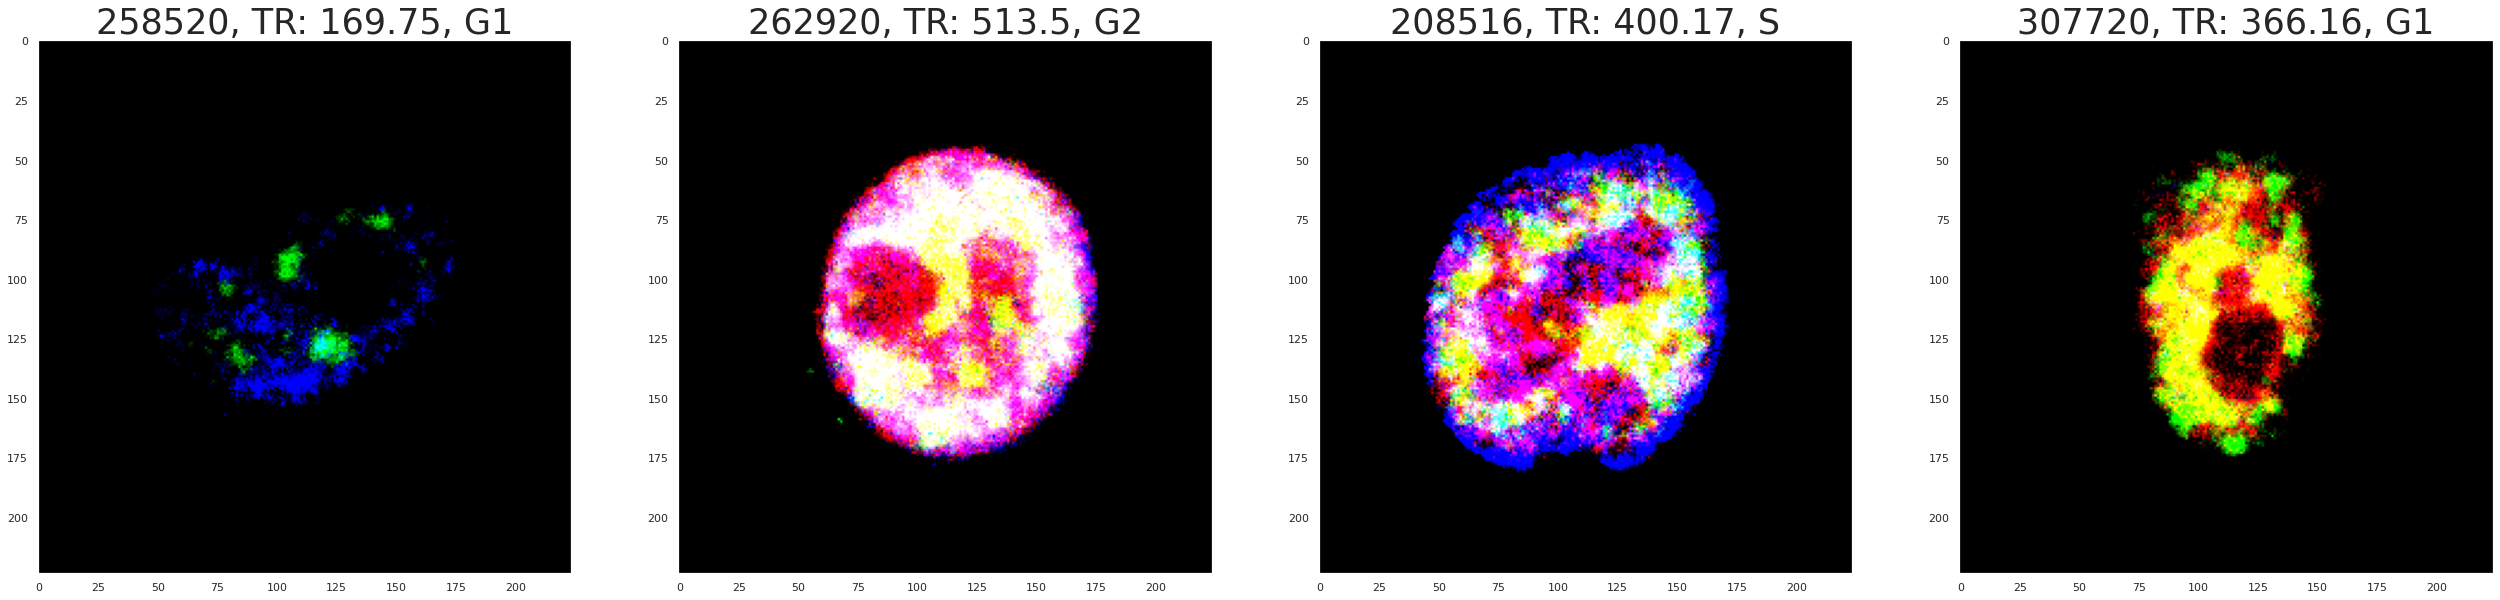

In [16]:
# Load cell, compute its Score map and save it
score_maps_dir = os.path.join(params['score_maps_path'], 'data')
#params['cells'] = big_cells
n_cells = len(params['cells'])
big_cells
plt.figure(figsize=(n_cells*11,10))
dss = [train_data, val_data]
ds_names = ['train', 'val']
cell_count = 0
cells = {}
for ds, dsn in zip(dss, ds_names):
    for cell in ds:
        # get cell id
        cell_id = cell['mapobject_id_cell'].numpy()
        cell_id = str(cell_id.decode())

        if cell_id in params['cells']:
            cell_count += 1
            print('Opening cell: {}, {}/{}'.format(cell_id, cell_count, n_cells))
            
            cells[cell_id+'_img'] = cell['image'].numpy()
            cells[cell_id+'_img'] = cells[cell_id+'_img'][:,:,input_ids].astype(np.float32)
            
            cells[cell_id+'_mask'] = cell['image'].numpy()
            cells[cell_id+'_mask'] = cells[cell_id+'_mask'][:,:,-1]
            cells[cell_id+'_mask'] = cells[cell_id+'_mask'].astype(np.bool)
            
            # load score map
            temp_path = os.path.join(score_maps_dir, cell_id+'.npy')
            cells[cell_id+'_sm'] = np.load(temp_path)
            
            # Plot cells
            temp_img = cells[cell_id+'_img'][:,:,10:13]
            plt.subplot(1, n_cells, cell_count)

            # Get TR
            TR = cell['target'].numpy()[0]
            # get cc
            mask = targets_df.mapobject_id_cell == cell_id
            cc = targets_df[mask].cell_cycle.values[0]
            print(targets_df[mask].set.values)

            nn_inter.plot_cell(img=temp_img, title=cell_id+', TR: '+str(round(TR, 2))+', '+cc, title_fontsize=35)

In [17]:
from scipy import ndimage
from scipy.spatial.distance import directed_hausdorff

def compute_channel_difference_matrix(score_map, cell_mask, metric='mae'):
    n_channels = score_map.shape[-1]
    dist_mtx = np.zeros((n_channels, n_channels))
    N = cell_mask.sum()
    for i in range(n_channels):
        for j in range(n_channels):
            if metric == 'mae':
                dist_mtx[i,j] = (1 / N) * np.sum(np.abs(score_map[:,:,i] - score_map[:,:,j]))
            elif metric == 'hausdorff':
                dist_mtx[i,j] = directed_hausdorff(score_map[:,:,i], score_map[:,:,j])[0]
    
    # normalize values
    norm_param = dist_mtx.sum()
    dist_mtx /= norm_param
    
    return dist_mtx

def apply_gaussin_filter(img=None,  sigma=1):
    return ndimage.gaussian_filter(img, sigma)

def standardize_img(img, img_mask):
    channel_mean = img[img_mask].mean(axis=0)
    channel_stddev = img[img_mask].std(axis=0)

    img[img_mask] = img[img_mask] - channel_mean
    img[img_mask] = img[img_mask] / channel_stddev
    
    return img

def apply_percentile_clipping(img, img_mask, p=98):

    percentile_vector = np.percentile(img[img_mask], q=p, axis=0)

    n_channels = img.shape[-1]
    for c in range(n_channels):
        mask = (img[:,:,c] >= percentile_vector[c])
        img[:,:,c][mask] = percentile_vector[c]
        
    return img

def get_channels_dist(c1, c2, cell_mask, metric):
    N = cell_mask.sum()
    if metric == 'mae':
        return (1 / N) * np.sum(np.abs(c1 - c2))
    elif metric == 'hausdorff':
        return directed_hausdorff(c1, c2)[0]
    
def get_score_map_similarity(temp_score, temp_cell_img, cell_mask, metric='mae'):
    INF = np.inf
    n_channels =  temp_score.shape[-1]
    # similarity between score_map channels and score_map channels
    most_sim_sm_channel_id = []
    most_sim_sm_channel_dist = []
    # similarity between score_map channels and cell_img channels
    most_sim_channel_id = []
    most_sim_channel_dist = []
    for i in range(n_channels):
        sm_chanel_dist = []
        chanel_dist = []
        for j in range(n_channels):
            if i == j:
                # distance between a channel and itself is 0, therefore assign it INF
                sm_chanel_dist.append(INF)
            else:
                sm_chanel_dist.append(get_channels_dist(temp_score[:,:,i], temp_score[:,:,j], cell_mask, metric))
            # distances between the score_map channel j and cell_img channels
            chanel_dist.append(get_channels_dist(temp_score[:,:,i], temp_cell_img[:,:,j], cell_mask, metric))
        # save the most similar score_map channel to channel i
        most_sim_sm_channel_id.append(np.argmin(sm_chanel_dist))
        most_sim_sm_channel_dist.append(np.min(sm_chanel_dist))
        # save the most similar cell_img channel to score_map channel i
        most_sim_channel_id.append(np.argmin(chanel_dist))
        most_sim_channel_dist.append(np.min(chanel_dist))

    columns = [cn+'_idx' for cn in input_channel_names] + [cn+'_dist' for cn in input_channel_names]
    temp_arr = np.array(most_sim_sm_channel_id + most_sim_sm_channel_dist).reshape((1, -1))
    sm_to_sm_dist_df = pd.DataFrame(temp_arr, columns=columns)
    temp_arr = np.array(most_sim_channel_id + most_sim_channel_dist).reshape((1, -1))
    sm_to_ci_dist_df = pd.DataFrame(temp_arr, columns=columns)
    
    return sm_to_sm_dist_df, sm_to_ci_dist_df

In [18]:
metric = 'mae'
sm_to_sm_dist_df = pd.DataFrame()
sm_to_ci_dist_df = pd.DataFrame()

mask = tfds_metadata['metadata_df'].set == 'test'
params['cells'] = tfds_metadata['metadata_df'][~mask].mapobject_id_cell.unique().astype('str')

# Load cell, compute its Score map and save it
score_maps_dir = os.path.join(params['score_maps_path'], 'data')
#params['cells'] = big_cells
n_cells = len(params['cells'])
dss = [train_data, val_data]
ds_names = ['train', 'val']
cell_count = 0
for ds, dsn in zip(dss, ds_names):
    for cell in ds:
        # get cell id
        cell_id = cell['mapobject_id_cell'].numpy()
        cell_id = str(cell_id.decode())

        if cell_id in params['cells']:
            cell_count += 1
            print('Opening cell: {}, {}/{}'.format(cell_id, cell_count, n_cells))
            
            cell_img = cell['image'].numpy()
            cell_img = cell_img[:,:,input_ids].astype(np.float32)
            
            cell_mask = cell['image'].numpy()
            cell_mask = cell_mask[:,:,-1]
            cell_mask = cell_mask.astype(np.bool)
            
            # load score map
            temp_path = os.path.join(score_maps_dir, cell_id+'.npy')
            score_map = np.load(temp_path)
            
            # get channel similarity
            # preprocess
            score_map = standardize_img(score_map, cell_mask)
            cell_img = standardize_img(cell_img, cell_mask)
            # get sim
            smsm_df, smci_df = get_score_map_similarity(score_map, cell_img, cell_mask, metric)
            smsm_df['mapobject_id_cell'] = cell_id
            smci_df['mapobject_id_cell'] = cell_id
            sm_to_sm_dist_df = pd.concat((sm_to_sm_dist_df, smsm_df), axis=0, ignore_index=True)
            sm_to_ci_dist_df = pd.concat((sm_to_ci_dist_df, smci_df), axis=0, ignore_index=True)
            

Opening cell: 305670, 1/3332
Opening cell: 248989, 2/3332
Opening cell: 212764, 3/3332
Opening cell: 383254, 4/3332
Opening cell: 287059, 5/3332
Opening cell: 226855, 6/3332
Opening cell: 366430, 7/3332
Opening cell: 266507, 8/3332
Opening cell: 337246, 9/3332
Opening cell: 235351, 10/3332
Opening cell: 305662, 11/3332
Opening cell: 307724, 12/3332
Opening cell: 221647, 13/3332
Opening cell: 194797, 14/3332
Opening cell: 260099, 15/3332
Opening cell: 321007, 16/3332
Opening cell: 215865, 17/3332
Opening cell: 305667, 18/3332
Opening cell: 258520, 19/3332
Opening cell: 195221, 20/3332
Opening cell: 350656, 21/3332
Opening cell: 257458, 22/3332
Opening cell: 359335, 23/3332
Opening cell: 195549, 24/3332
Opening cell: 329080, 25/3332
Opening cell: 202822, 26/3332
Opening cell: 359020, 27/3332
Opening cell: 319175, 28/3332
Opening cell: 256525, 29/3332
Opening cell: 287403, 30/3332
Opening cell: 373523, 31/3332
Opening cell: 351026, 32/3332
Opening cell: 319183, 33/3332
Opening cell: 26854

In [19]:
sm_to_ci_dist_df

00_DAPI_idx  07_H2B_idx  01_CDK9_pT186_idx  03_CDK9_idx  05_GTF2B_idx  \
0             7.0        13.0               13.0         13.0          13.0   
1             0.0         7.0                7.0         13.0          26.0   
2            13.0        19.0               17.0         13.0          18.0   
3            18.0        17.0               18.0         13.0          18.0   
4             0.0         7.0                2.0          3.0          14.0   
...           ...         ...                ...          ...           ...   
3327         26.0        19.0               26.0         13.0          18.0   
3328         18.0        17.0               18.0         13.0          18.0   
3329          7.0         7.0                7.0          3.0          18.0   
3330         13.0        13.0               13.0         13.0          13.0   
3331         17.0        13.0               17.0         17.0          15.0   

      07_SETD1A_idx  08_H3K4me3_idx  09_SRRM2_idx  10_H3K27ac_idx  \
0               7.0             7.0           7.0            17.0   
1               7.0             7.0           7.0            19.0   
2               7.0             7.0           7.0            17.0   
3              13.0            13.0          13.0            17.0   
4               7.0             7.0           7.0            13.0   
...             ...             ...           ...             ...   
3327           13.0            13.0          13.0            19.0   
3328           13.0            18.0          13.0            17.0   
3329           13.0             7.0           7.0            26.0   
3330           13.0            13.0          13.0            13.0   
3331           13.0            13.0           7.0            15.0   

      11_KPNA2_MAX_idx  12_RB1_pS807_S811_idx  13_PABPN1_idx  14_PCNA_idx  \
0                 13.0                    7.0           13.0          7.0   
1                 13.0                   13.0           13.0         26.0   
2                 19.0                   18.0            7.0         17.0   
3                 17.0                   18.0           13.0         17.0   
4                  7.0                    7.0            7.0         17.0   
...                ...                    ...            ...          ...   
3327              19.0                   17.0           13.0         19.0   
3328              17.0                   17.0           13.0         17.0   
3329              13.0                   26.0            7.0         13.0   
3330              13.0                   13.0           13.0          7.0   
3331              15.0                   17.0           13.0         26.0   

      15_SON_idx  16_H3_idx  17_HDAC3_idx  19_KPNA1_MAX_idx  20_SP100_idx  \
0           13.0       19.0           7.0              13.0          17.0   
1           13.0       19.0          13.0              16.0          17.0   
2           13.0       17.0           7.0              17.0          17.0   
3           13.0       17.0          13.0              18.0          17.0   
4           13.0       14.0           7.0              16.0          17.0   
...          ...        ...           ...               ...           ...   
3327        13.0       19.0          15.0              16.0          17.0   
3328        13.0       17.0          17.0              18.0          17.0   
3329        13.0       26.0           7.0               7.0          17.0   
3330        13.0       17.0          13.0              13.0          17.0   
3331        13.0       15.0          15.0              13.0          17.0   

      21_NCL_idx  01_PABPC1_idx  02_CDK7_idx  03_RPS6_idx  05_Sm_idx  \
0           18.0           13.0         13.0         18.0       13.0   
1           18.0           19.0         13.0         18.0       18.0   
2           18.0           18.0         17.0         18.0       18.0   
3           18.0           18.0         18.0         18.0       18.0   
4           17.0  

# Similarity between score_maps channels and cell_image channels

[13 17  7 18 26]


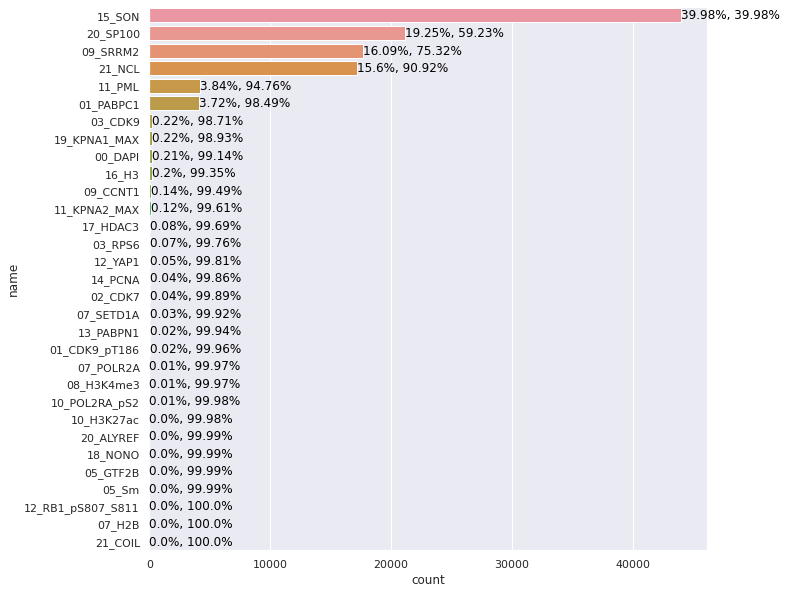

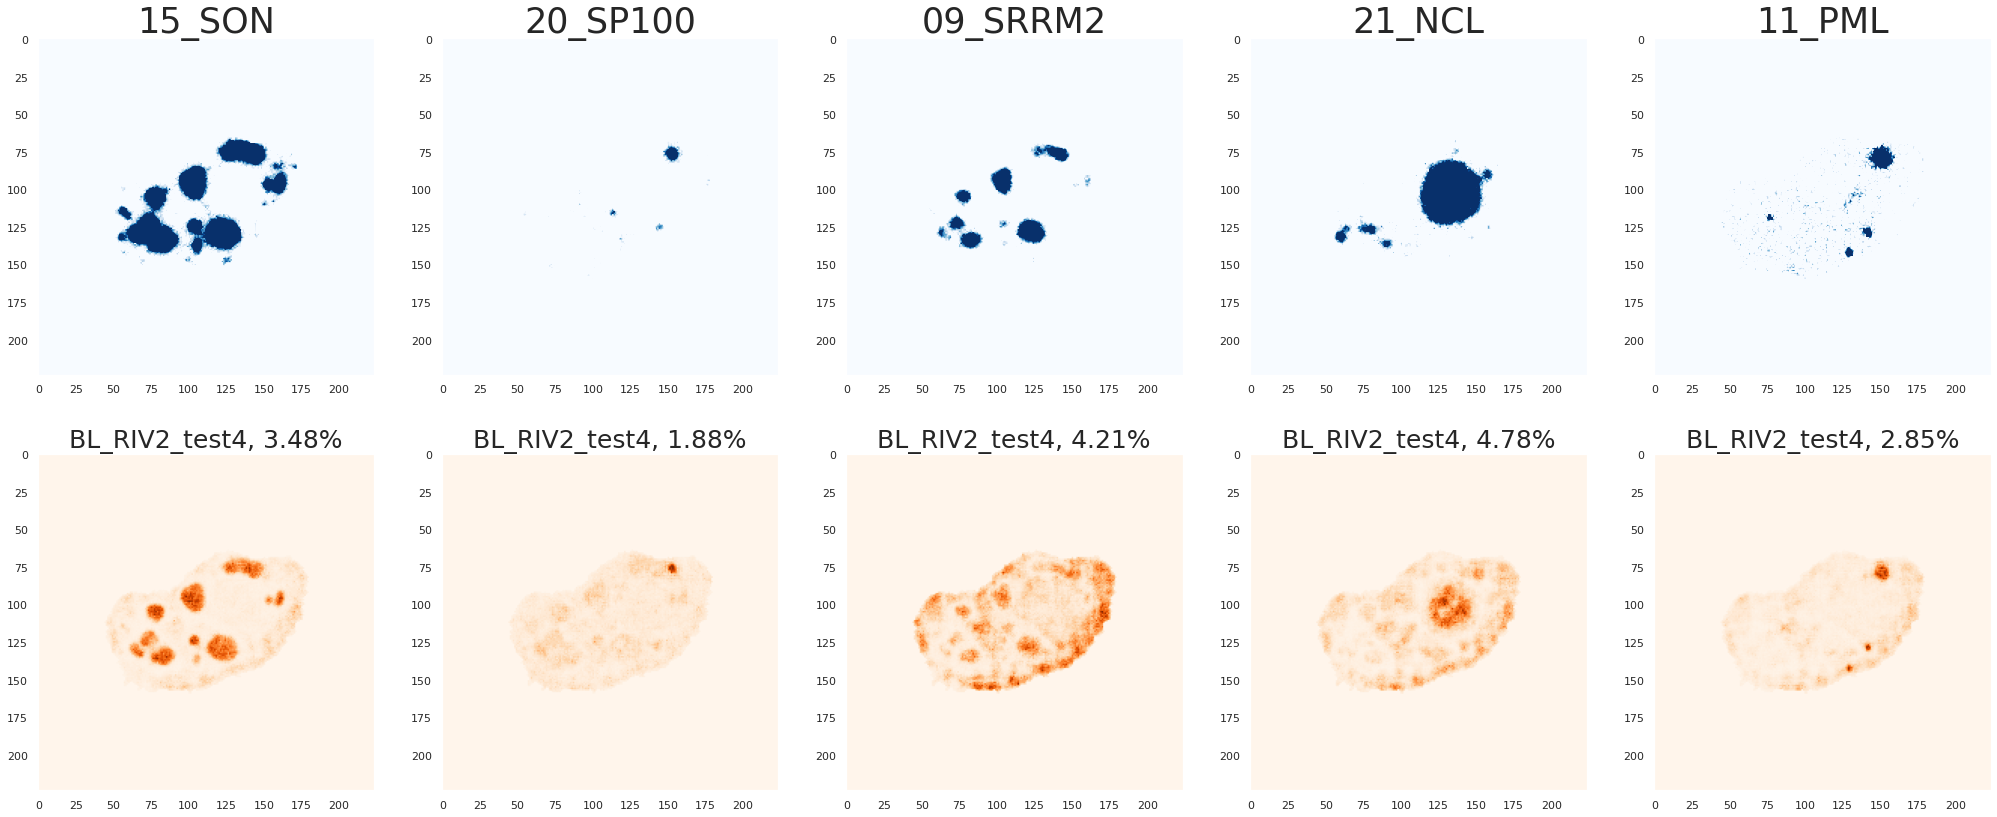

In [200]:
# Channels sorted by similarity counts
columns = [cn+'_idx' for cn in input_channel_names] + ['mapobject_id_cell']
temp_df = sm_to_ci_dist_df.copy()
temp_df = temp_df[columns].set_index('mapobject_id_cell').stack()
temp_df = temp_df.reset_index()
temp_df.columns = ['mapobject_id_cell', 'channel', 'idx']

channel_counts = temp_df['idx'].value_counts().reset_index().copy()
channel_counts.columns = ['TFDS_channel_id', 'count']
total_counts = channel_counts['count'].sum()
channel_counts['percent'] = channel_counts['count'] / total_counts
channel_counts['cum_percent'] = channel_counts['count'].cumsum() / total_counts
channel_counts = channel_counts.merge(channels_df[['TFDS_channel_id', 'name']],
                             left_on='TFDS_channel_id',
                             right_on='TFDS_channel_id',
                             how='left'
                            )

plt.figure(figsize=(10,10))
g = sns.barplot(data=channel_counts,
            y='name',
            x='count',
            orient="h"
           )
# add per cents
for _, row in channel_counts.iterrows():
    text = str(round(100 * row.percent,2))+'%, '+str(round(100 * row.cum_percent,2))+'%'
    g.text(row['count'], row.name, text, color='black', ha="left", va="center")
    
# plot top channels
# take one cell from the sample
cell_id = '258520'
score_map = cells[cell_id+'_sm']
cell_img = cells[cell_id+'_img']
cell_mask = cells[cell_id+'_mask']
# select the most important channels
mask = channel_counts['cum_percent'] <= 0.95
names_channels_2_plot = channel_counts[mask].name.values
channels_2_plot = channels_df.set_index('name').loc[names_channels_2_plot].TFDS_channel_id.astype(np.int16).values
print(channels_2_plot)

nn_inter.plot_VarGrad_IG_2(img=cell_img,
                           img_mask=cell_mask,
                           score_maps={'BL_RIV2_test4': score_map},
                           top_percent=1,
                           channels_df=channels_df,
                           img_size=(7,7),
                           score_map_same_sacale=False,
                           channels_2_plot=channels_2_plot,
                           plot_overlap=False,
                           plot_colorbar=False,
                           plot_name=None#'./Plots/BL_VarGrad_'+cell+'_0_5.png'
                            )

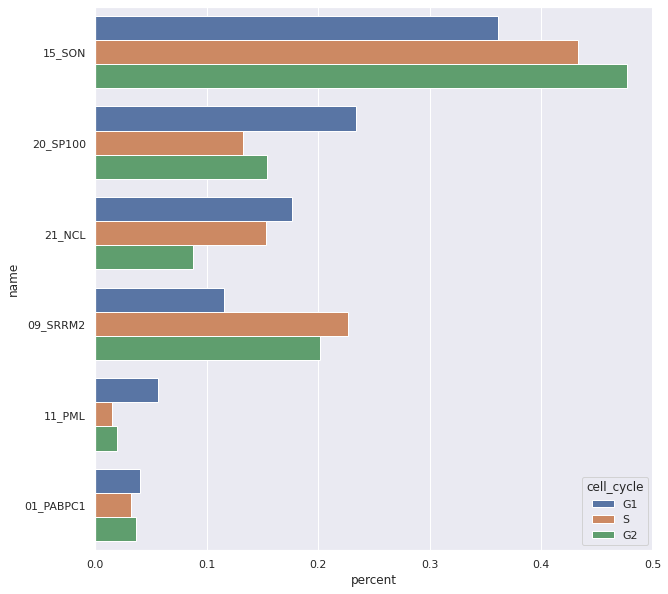

In [248]:
# Separated by cc
columns = [cn+'_idx' for cn in input_channel_names] + ['mapobject_id_cell']
temp_df = sm_to_ci_dist_df.copy()
temp_df = temp_df[columns].set_index('mapobject_id_cell').stack()
temp_df = temp_df.reset_index()
temp_df.columns = ['mapobject_id_cell', 'channel', 'idx']
temp_df = temp_df.merge(score_map_stddev[['mapobject_id_cell', 'cell_cycle', 'TR_Level']],
                  left_on='mapobject_id_cell',
                   right_on='mapobject_id_cell',
                   how='left'
                  )

channel_counts_per_TRL = pd.DataFrame()
for cc in temp_df.cell_cycle.unique():
    mask = (temp_df.cell_cycle == cc)
    
    channel_counts = temp_df[mask]['idx'].copy()
    channel_counts = channel_counts.value_counts().reset_index()
    channel_counts.columns = ['TFDS_channel_id', 'count']
    total_counts = channel_counts['count'].sum()
    channel_counts['percent'] = channel_counts['count'] / total_counts
    channel_counts['cum_percent'] = channel_counts['count'].cumsum() / total_counts
    channel_counts = channel_counts.merge(channels_df[['TFDS_channel_id', 'name']],
                                 left_on='TFDS_channel_id',
                                 right_on='TFDS_channel_id',
                                 how='left'
                                )
    channel_counts['cell_cycle'] = cc
    channel_counts_per_TRL = pd.concat((channel_counts_per_TRL, channel_counts), axis=0, ignore_index=True)

# Show only top
total_counts = channel_counts_per_TRL['count'].sum()
temp2_df = channel_counts_per_TRL.groupby(['name']).sum().reset_index()
temp2_df = temp2_df.sort_values(by='count', ascending=False)
temp2_df['percent'] = temp2_df['count'] / total_counts
temp2_df['cum_percent'] = temp2_df['percent'].cumsum()
top_channels = temp2_df.head(6).name.values
mask = channel_counts_per_TRL.name.isin(top_channels)

filtered_df = channel_counts_per_TRL[mask].copy().reset_index()
    
plt.figure(figsize=(10,10))
g = sns.barplot(data=filtered_df,
            y='name',
            x='percent',
            orient="h",
            hue='cell_cycle',
            hue_order=['G1', 'S', 'G2']
           )

<ipython-input-167-eb816bc3201c>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(10,10))


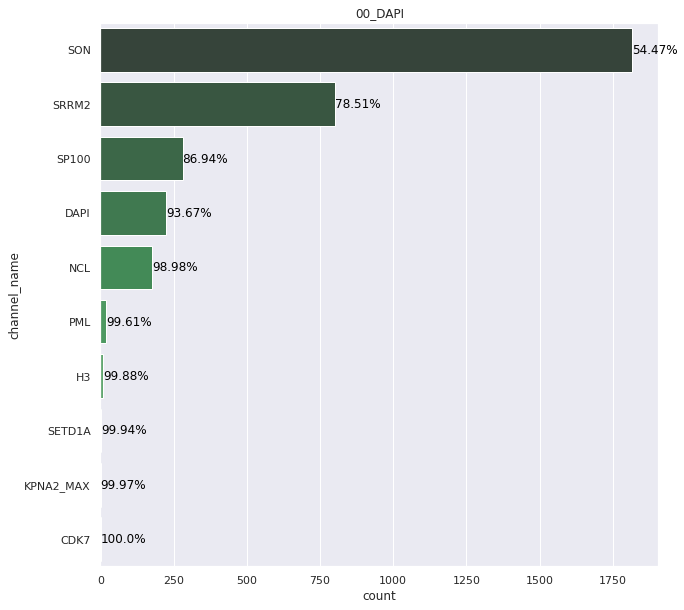

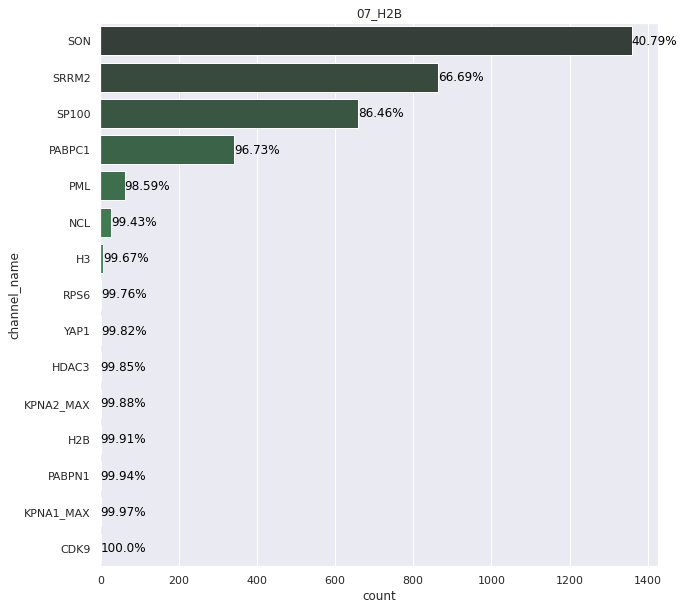

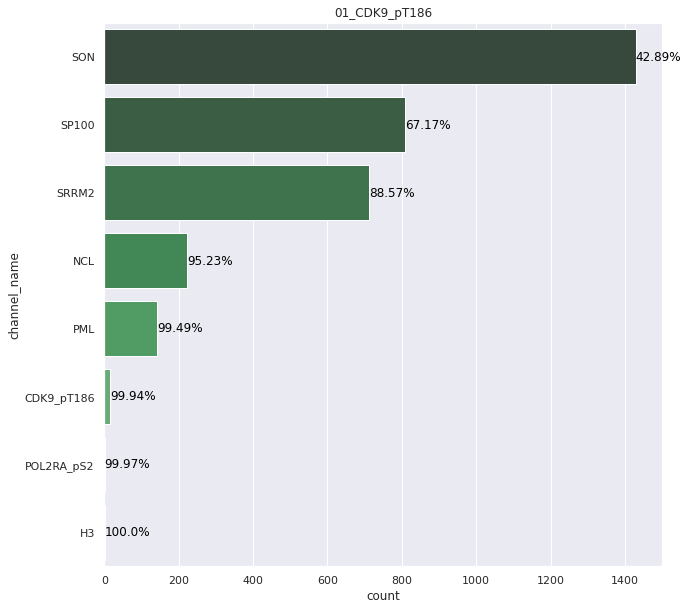

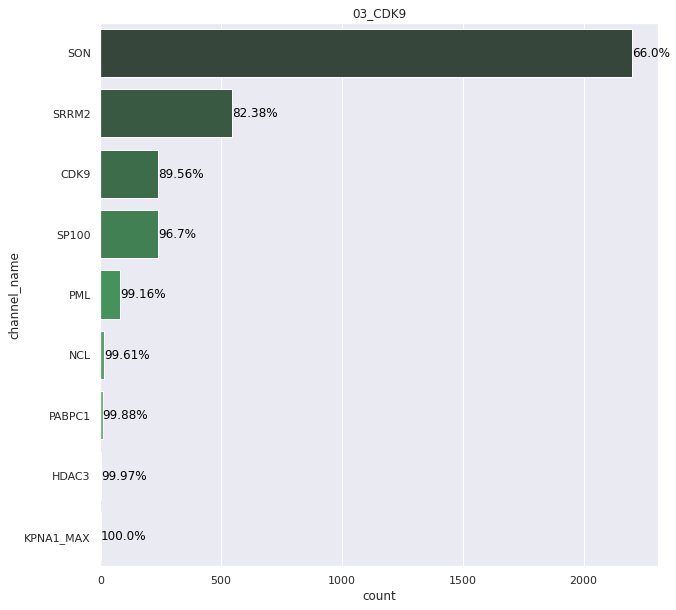

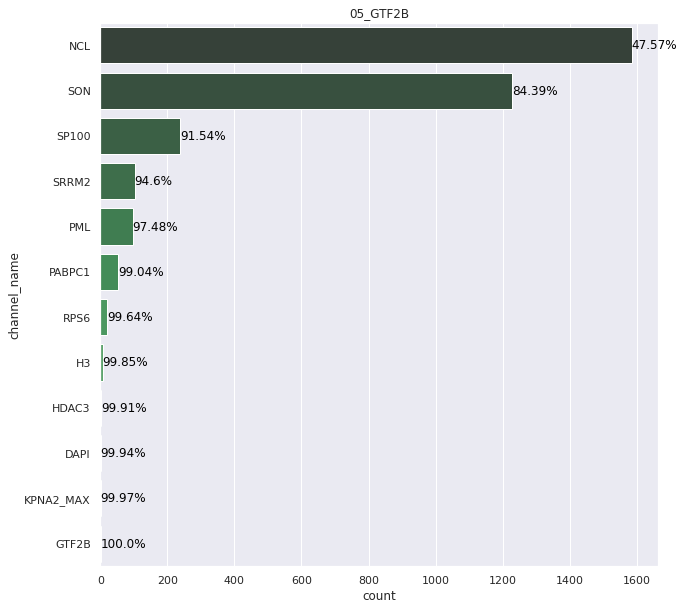

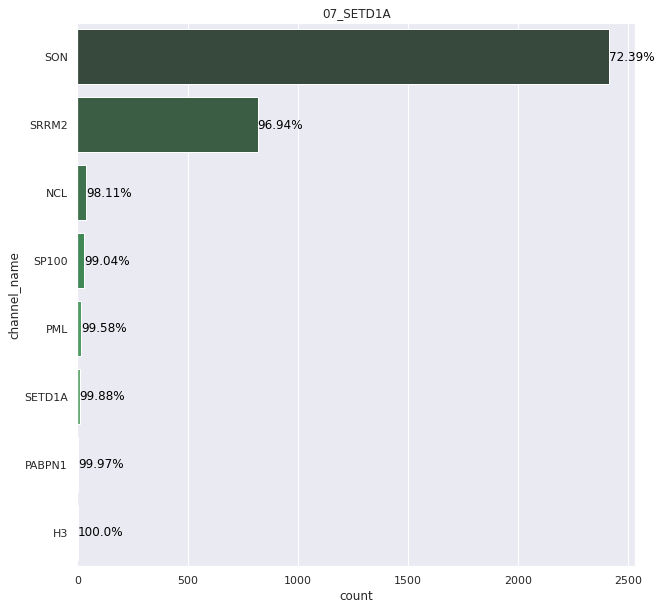

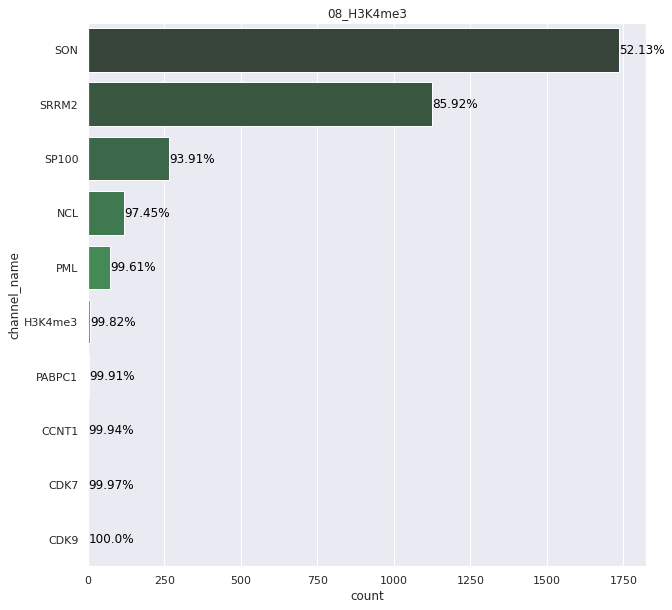

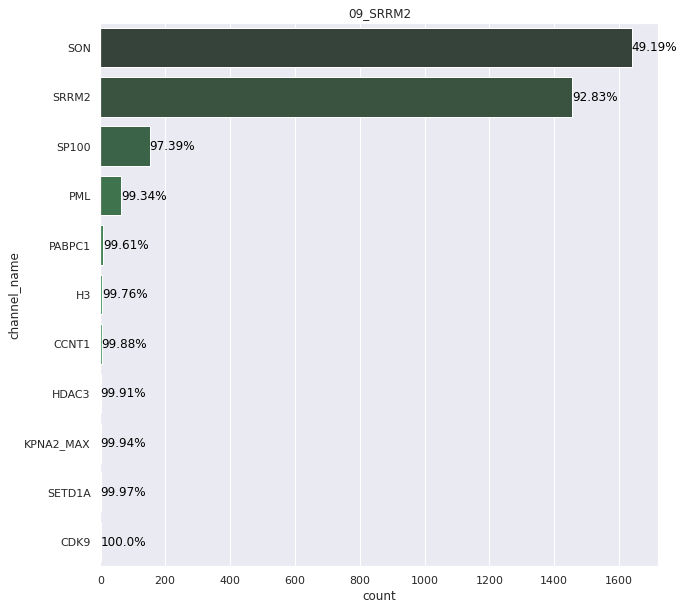

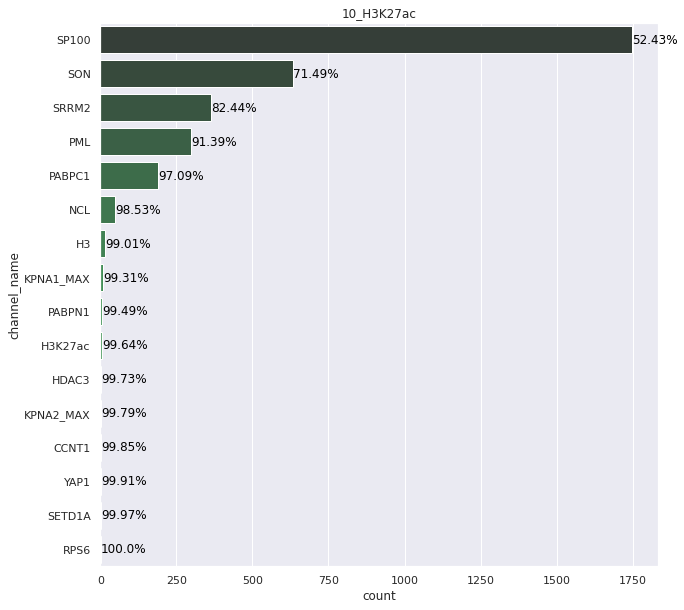

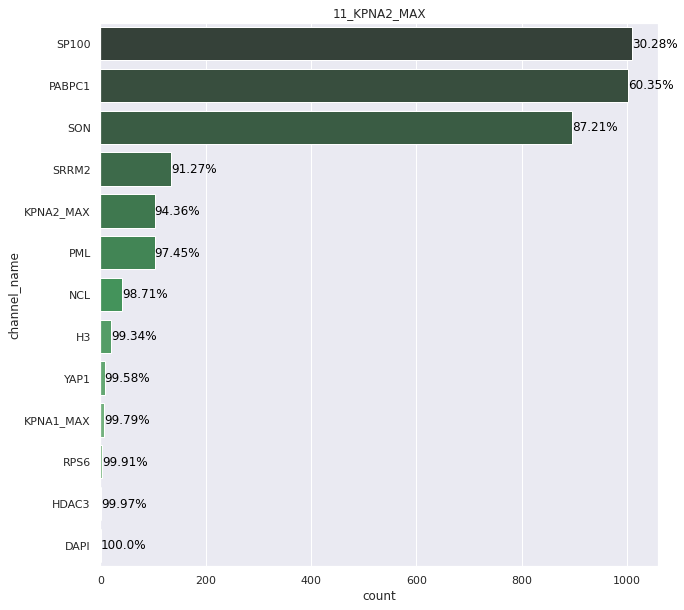

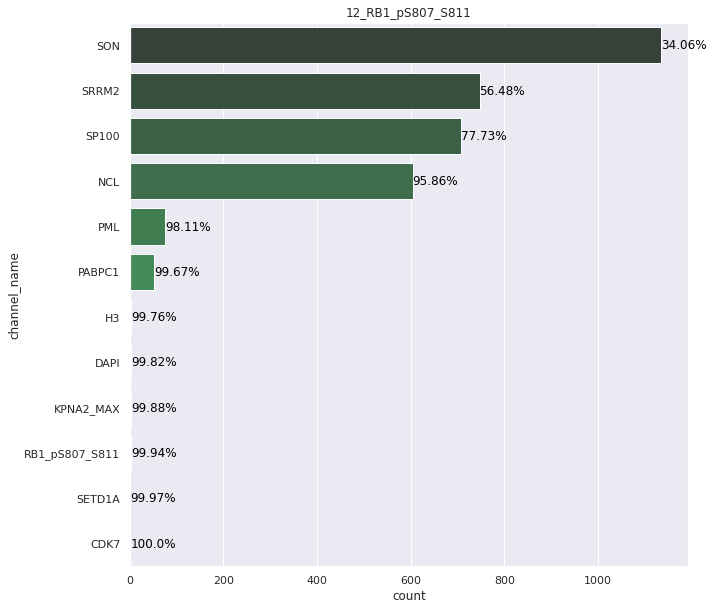

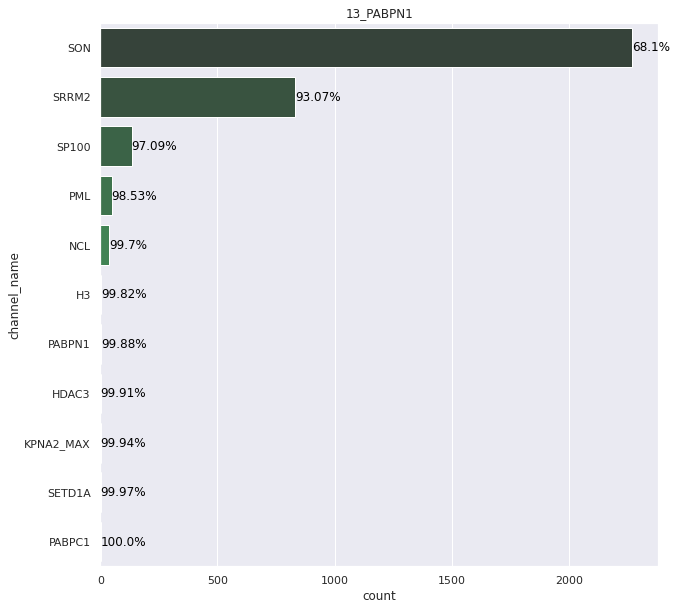

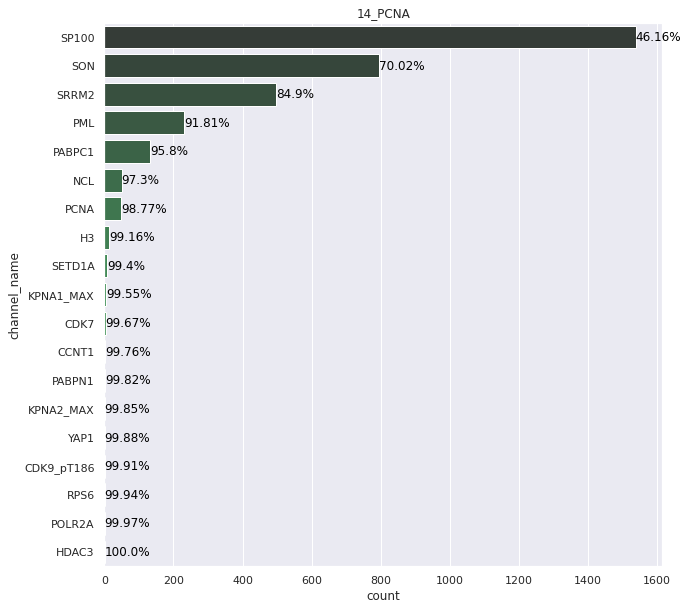

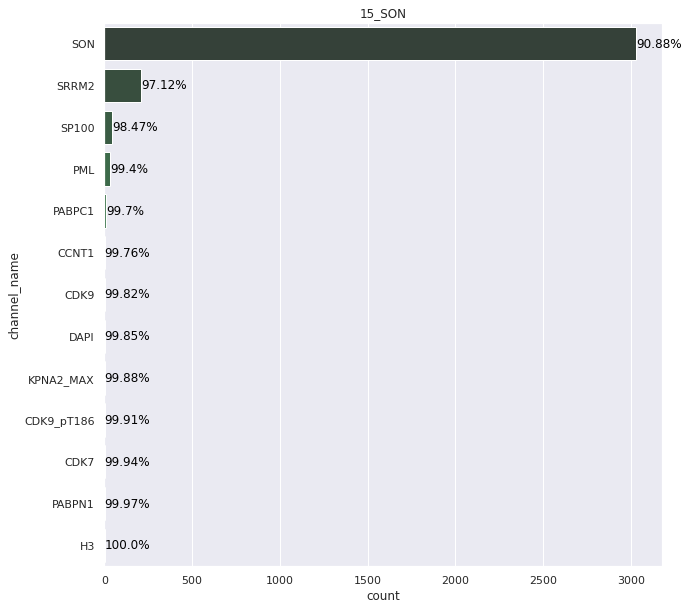

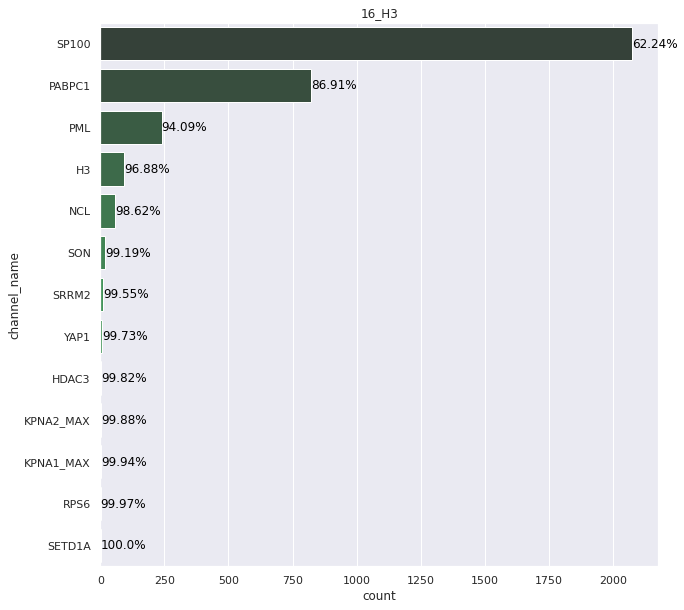

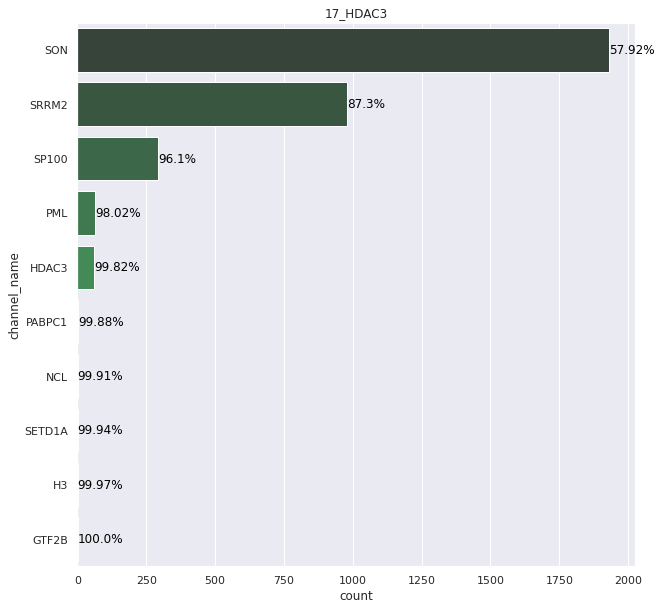

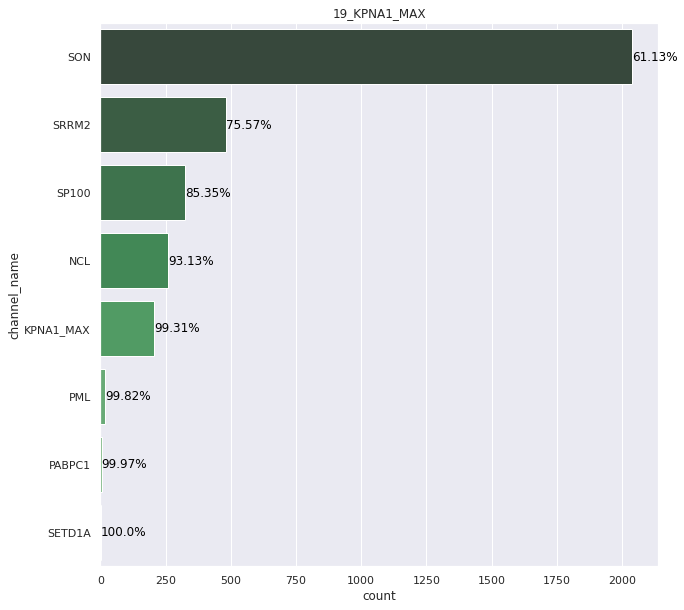

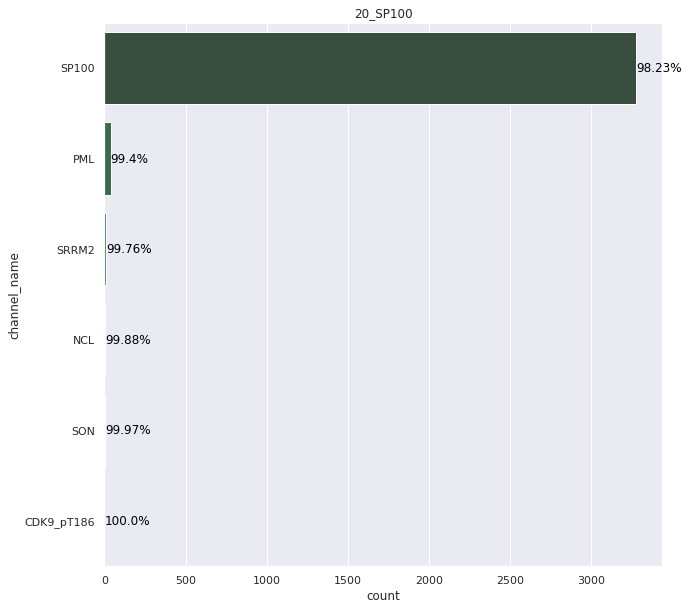

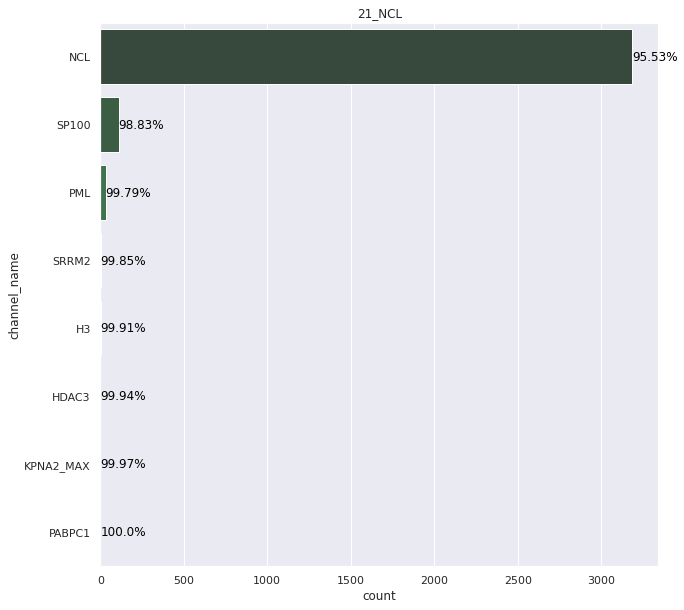

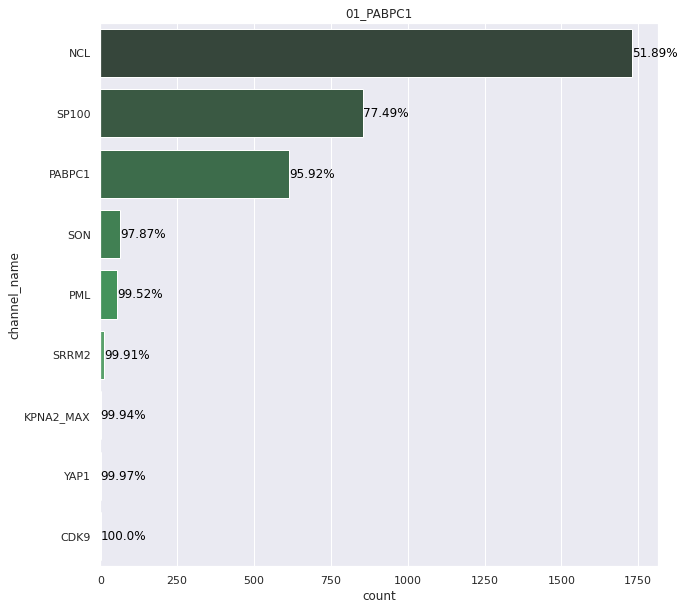

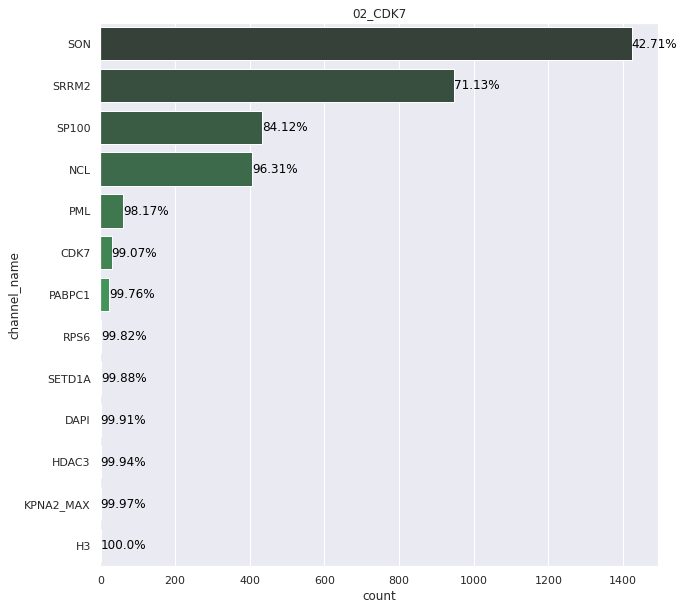

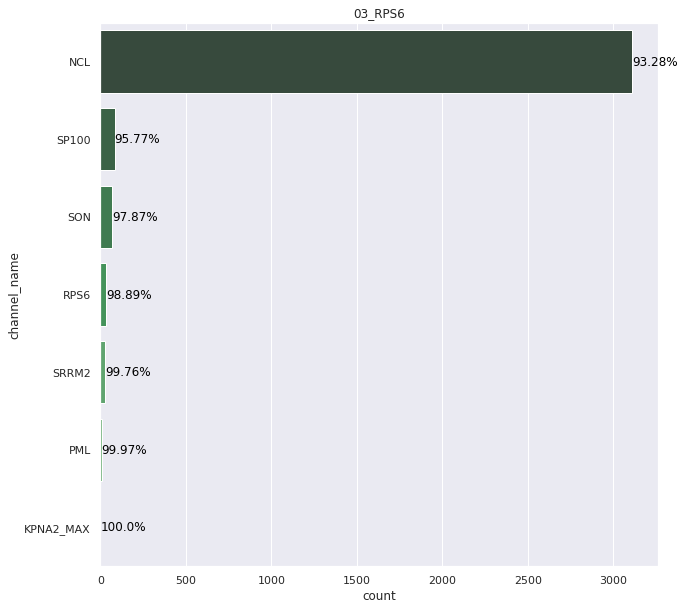

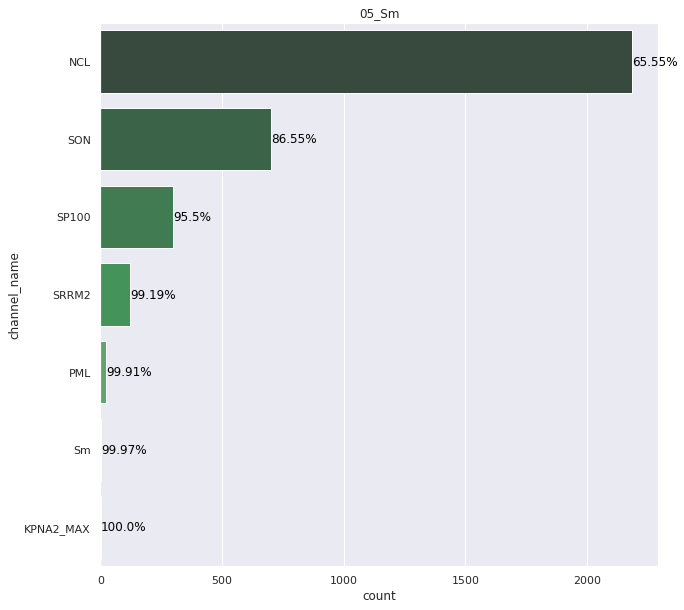

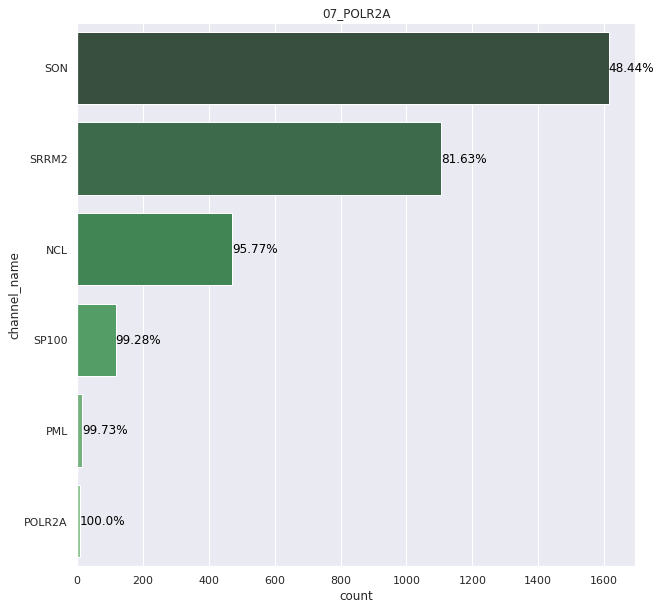

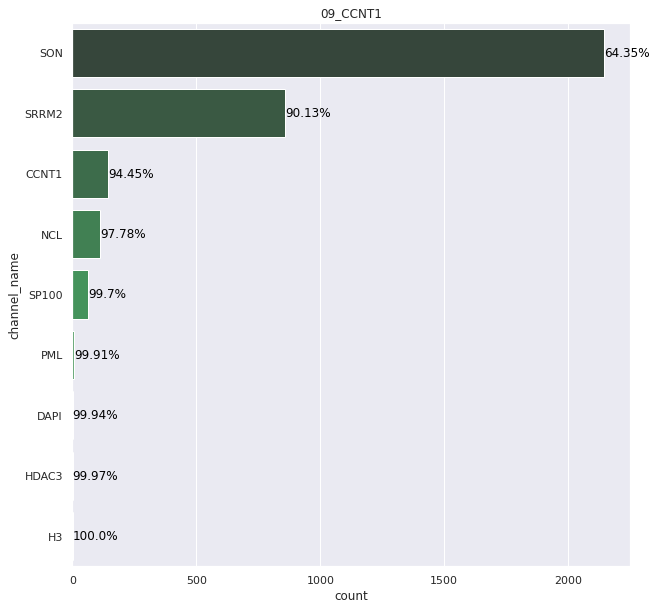

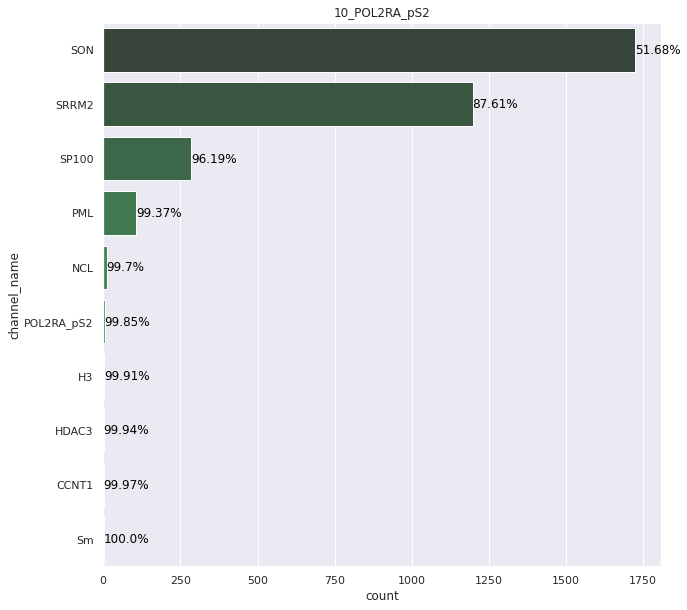

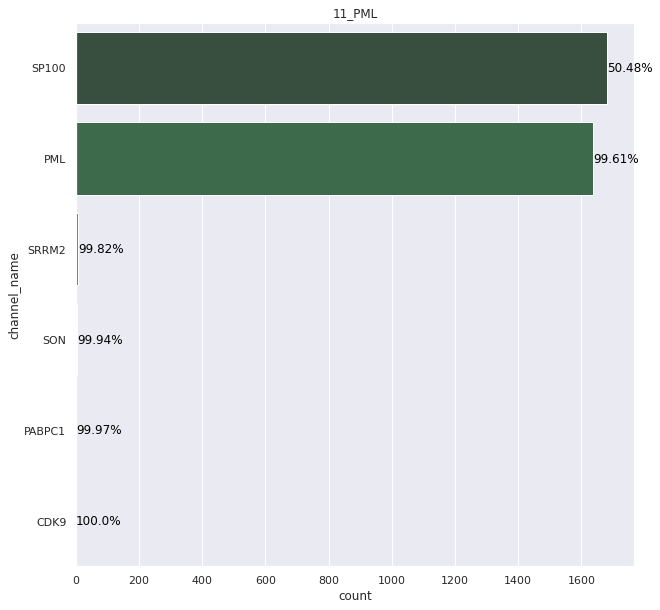

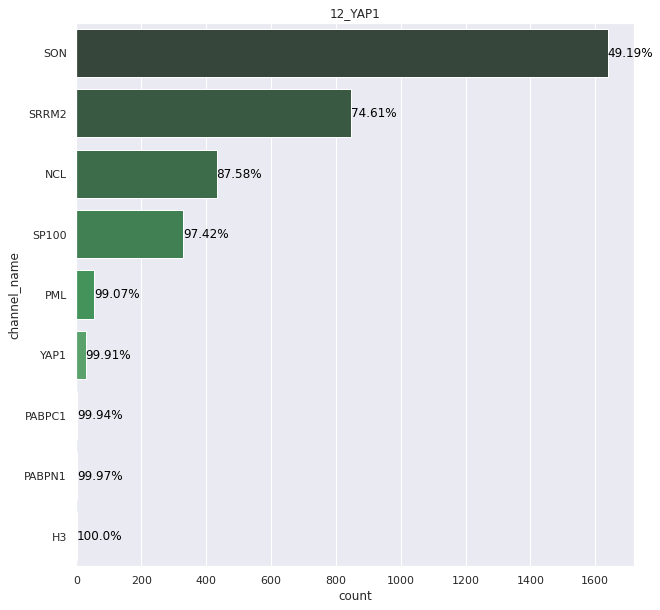

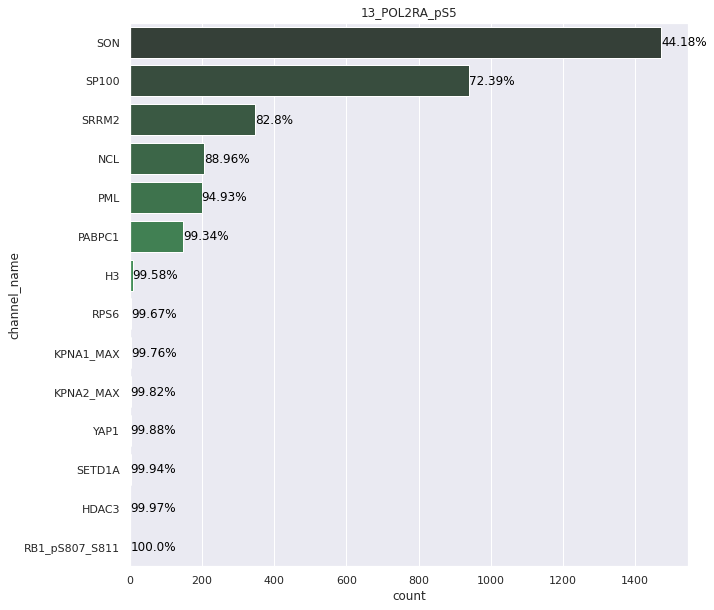

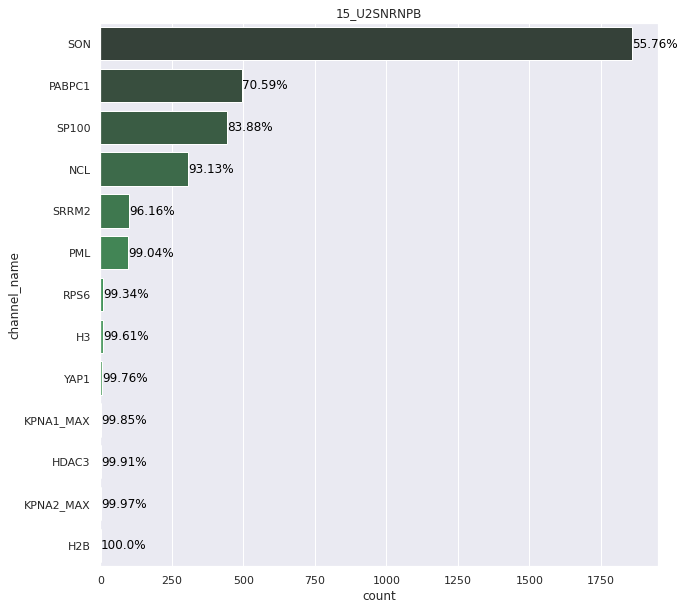

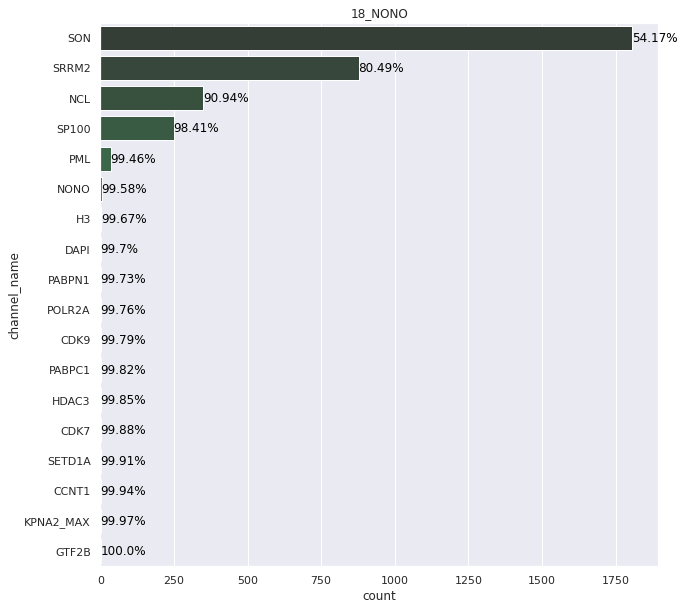

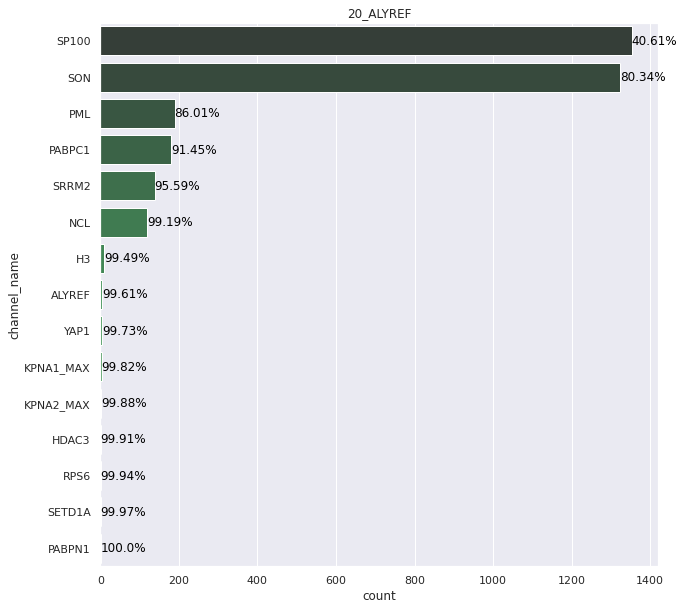

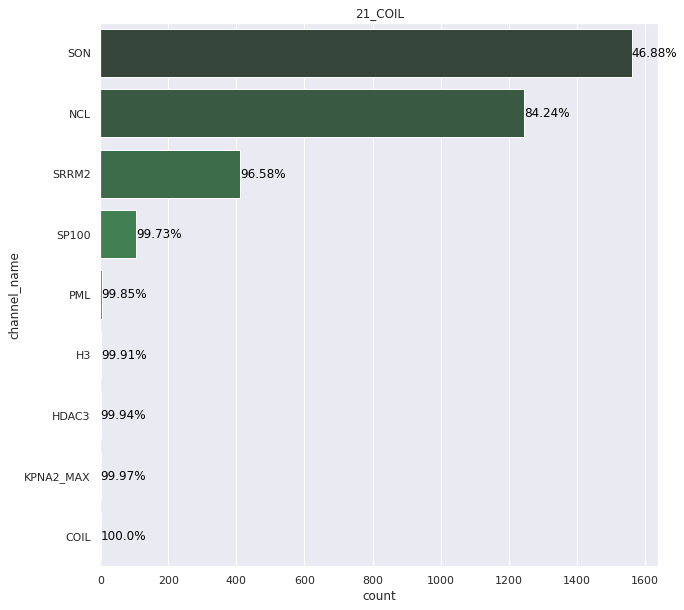

In [167]:
for c in input_channel_names:
    temp_df = sm_to_ci_dist_df[c+'_idx'].copy()
    channel_counts = temp_df.value_counts().reset_index()
    channel_counts.columns = ['TFDS_channel_id', 'count']
    total_counts = channel_counts['count'].sum()
    channel_counts['cum_percent'] = channel_counts['count'].cumsum() / total_counts
    channel_counts = channel_counts.merge(channels_df[['TFDS_channel_id', 'channel_name']],
                             left_on='TFDS_channel_id',
                             right_on='TFDS_channel_id',
                             how='left'
                            )
    plt.figure(figsize=(10,10))
    pal = sns.color_palette("Greens_d", channel_counts.shape[0])
    g = sns.barplot(data=channel_counts,
                    y='channel_name',
                    x='count',
                    palette=np.array(pal[::-1]),
                    orient="h"
                   )
    plt.title(c)
    # add per cents
    for _, row in channel_counts.iterrows():
        g.text(row['count'], row.name, str(round(100 * row.cum_percent,2))+'%', color='black', ha="left", va="center")


# Similarity between score_maps channels and score_maps chanels

[11  5  9 22 31 29 21 28  7 18  4 23 25 14 30 26  6 17 32 12 13  1  8]


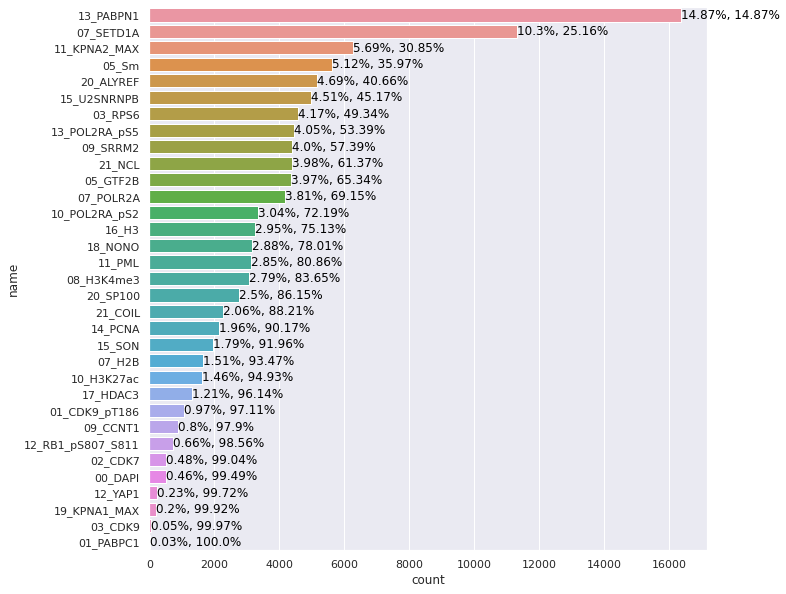

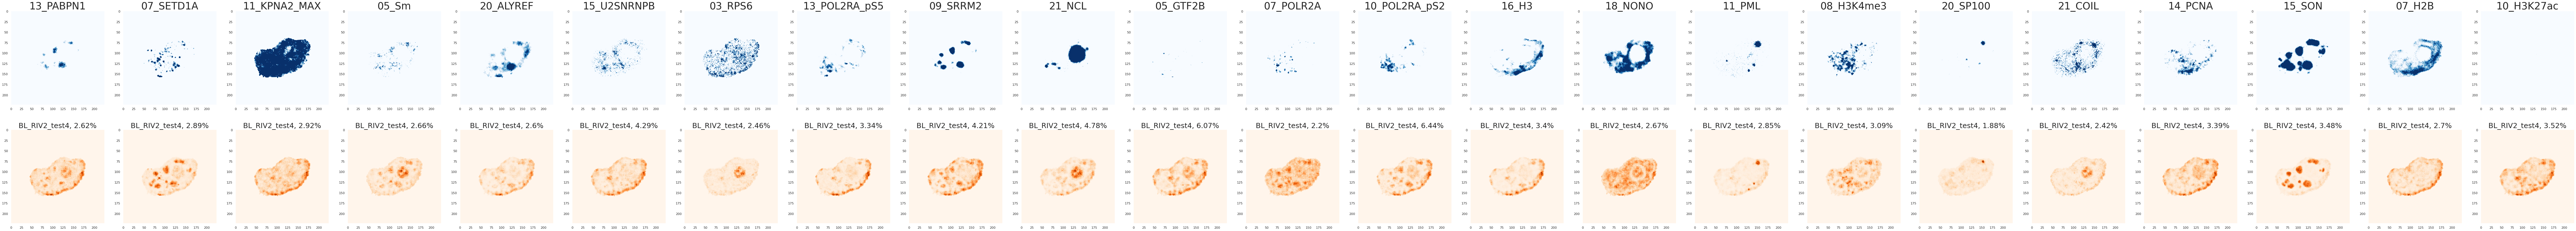

In [193]:
# Channels sorted by similarity counts
columns = [cn+'_idx' for cn in input_channel_names] + ['mapobject_id_cell']
temp_df = sm_to_sm_dist_df.copy()
temp_df = temp_df[columns].set_index('mapobject_id_cell').stack()
temp_df = temp_df.reset_index()
temp_df.columns = ['mapobject_id_cell', 'channel', 'idx']

channel_counts = temp_df['idx'].value_counts().reset_index().copy()
channel_counts.columns = ['TFDS_channel_id', 'count']
total_counts = channel_counts['count'].sum()
channel_counts['percent'] = channel_counts['count'] / total_counts
channel_counts['cum_percent'] = channel_counts['count'].cumsum() / total_counts
channel_counts = channel_counts.merge(channels_df[['TFDS_channel_id', 'name']],
                             left_on='TFDS_channel_id',
                             right_on='TFDS_channel_id',
                             how='left'
                            )

plt.figure(figsize=(10,10))
g = sns.barplot(data=channel_counts,
            y='name',
            x='count',
            orient="h"
           )
# add per cents
for _, row in channel_counts.iterrows():
    text = str(round(100 * row.percent,2))+'%, '+str(round(100 * row.cum_percent,2))+'%'
    g.text(row['count'], row.name, text, color='black', ha="left", va="center")
    
# plot top channels
# take one cell from the sample
cell_id = '258520'
score_map = cells[cell_id+'_sm']
cell_img = cells[cell_id+'_img']
cell_mask = cells[cell_id+'_mask']
# select the most important channels
mask = channel_counts['cum_percent'] <= 0.95
names_channels_2_plot = channel_counts[mask].name.values
channels_2_plot = channels_df.set_index('name').loc[names_channels_2_plot].TFDS_channel_id.astype(np.int16).values
print(channels_2_plot)

nn_inter.plot_VarGrad_IG_2(img=cell_img,
                           img_mask=cell_mask,
                           score_maps={'BL_RIV2_test4': score_map},
                           top_percent=1,
                           channels_df=channels_df,
                           img_size=(7,7),
                           score_map_same_sacale=False,
                           channels_2_plot=channels_2_plot,
                           plot_overlap=False,
                           plot_colorbar=False,
                           plot_name=None#'./Plots/BL_VarGrad_'+cell+'_0_5.png'
                            )

<ipython-input-164-ca5612c84310>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(10,10))


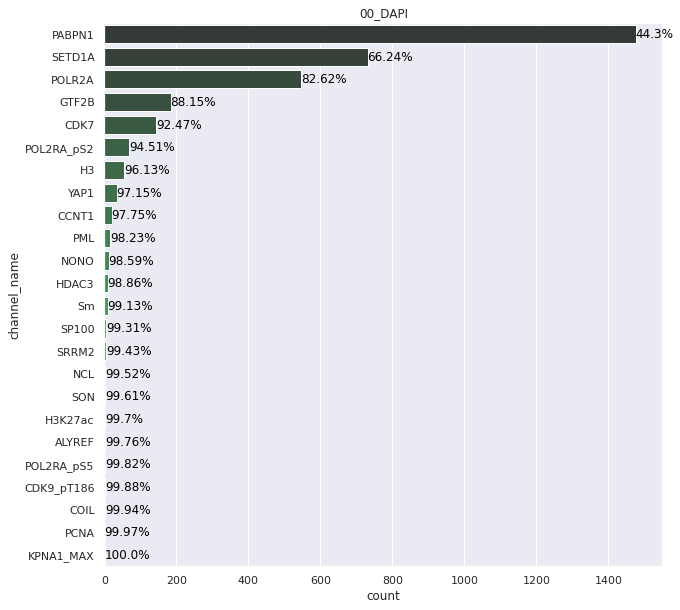

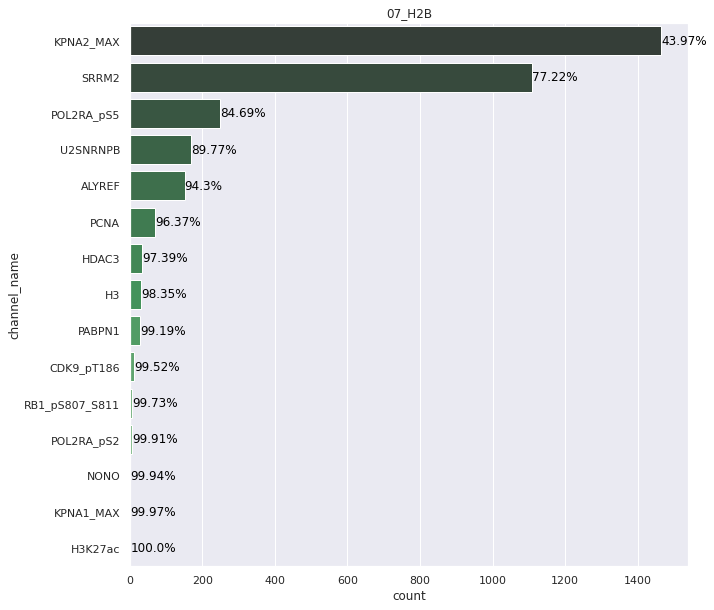

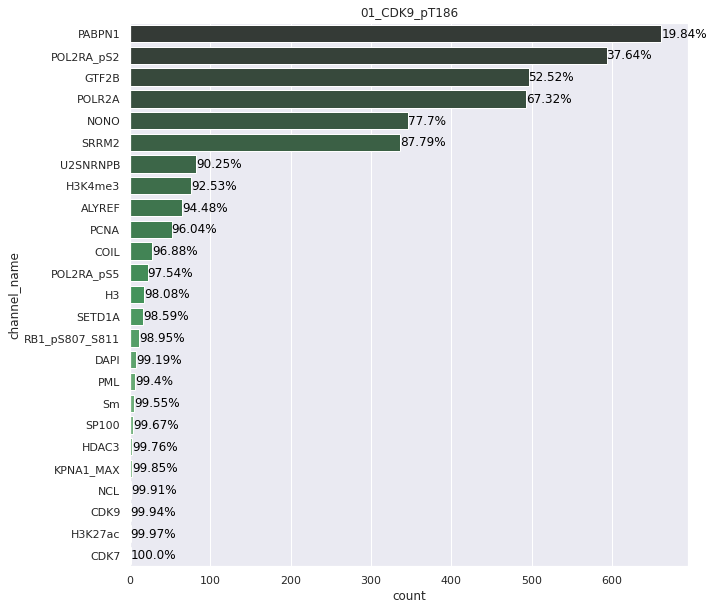

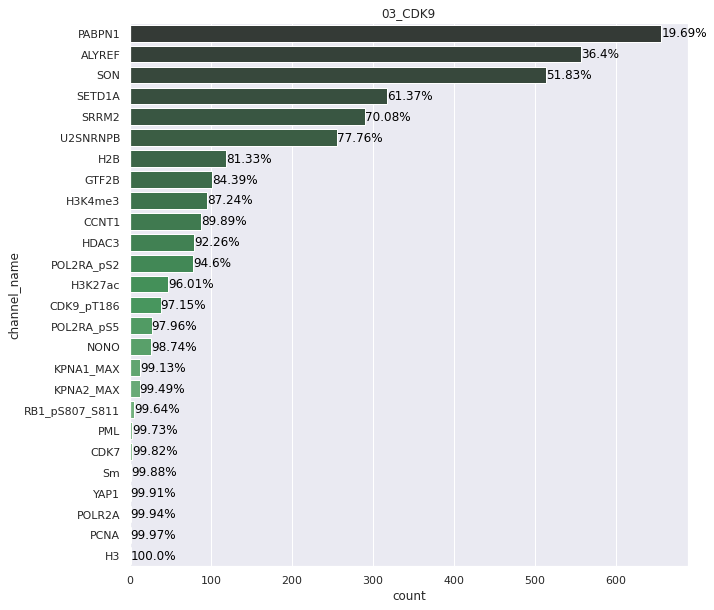

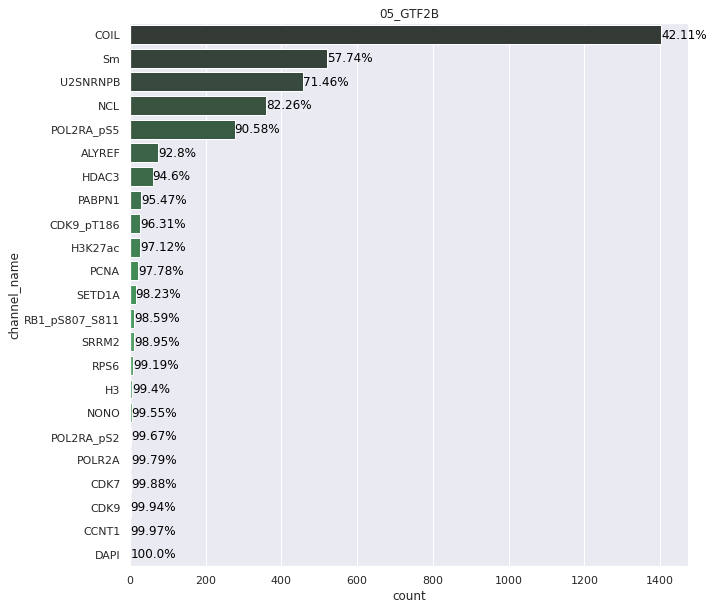

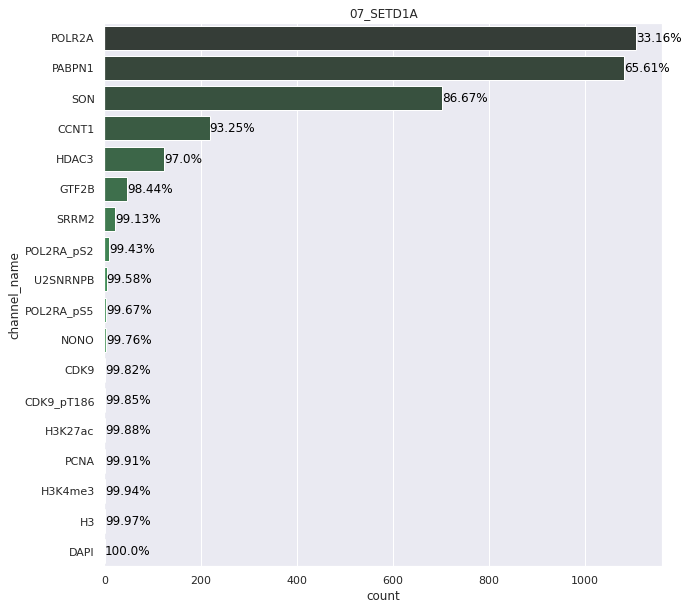

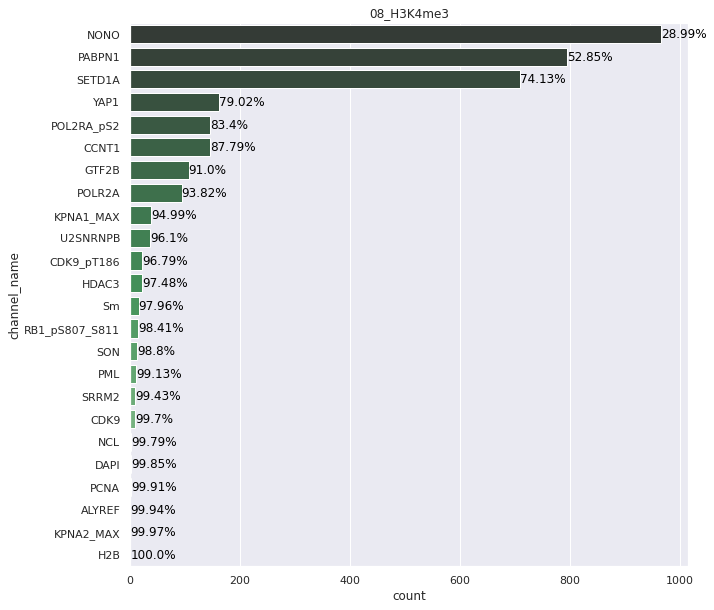

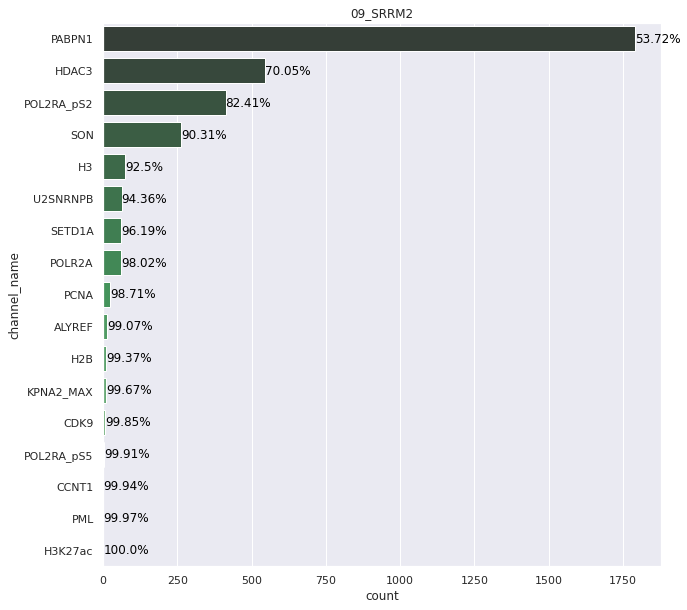

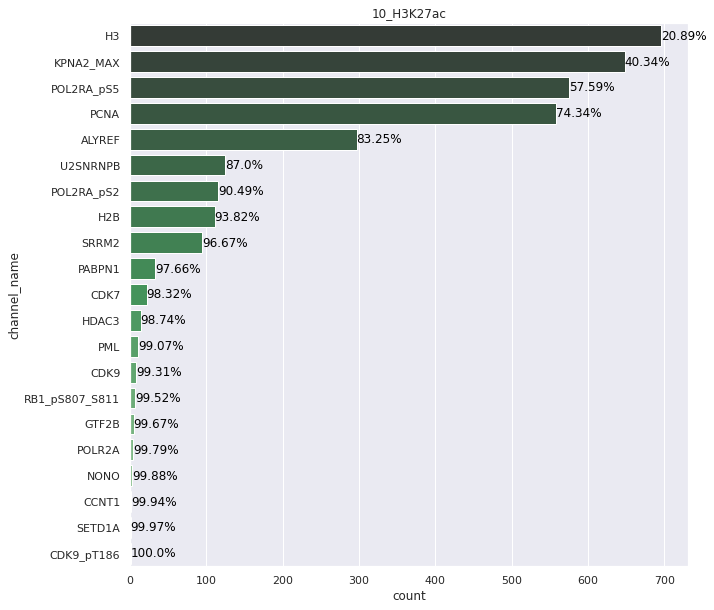

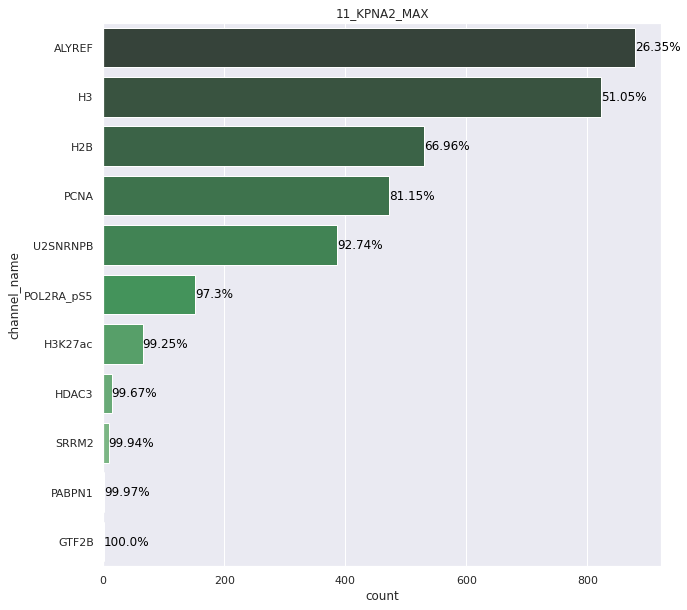

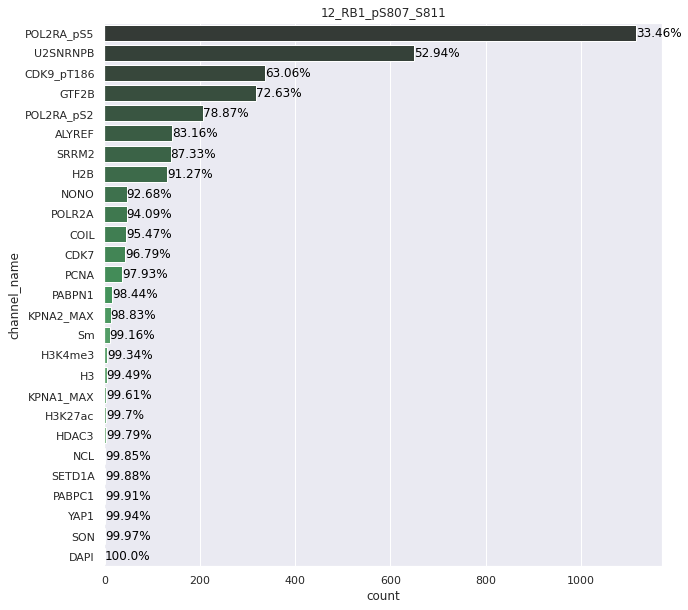

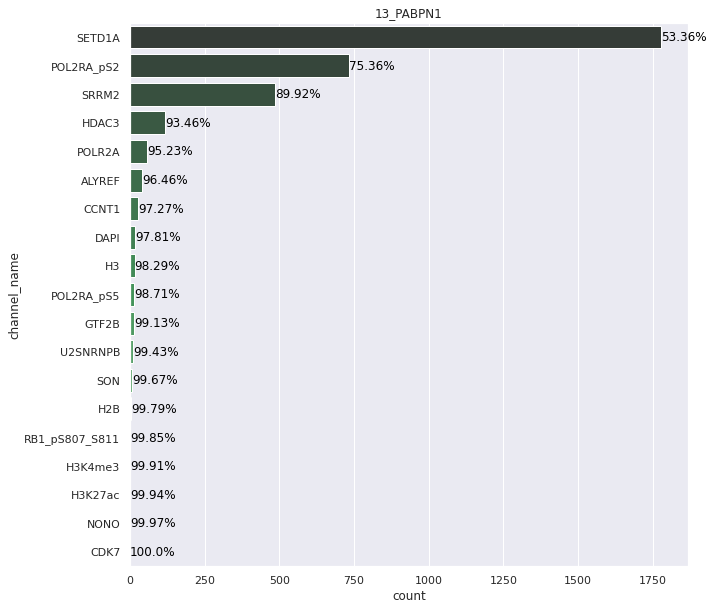

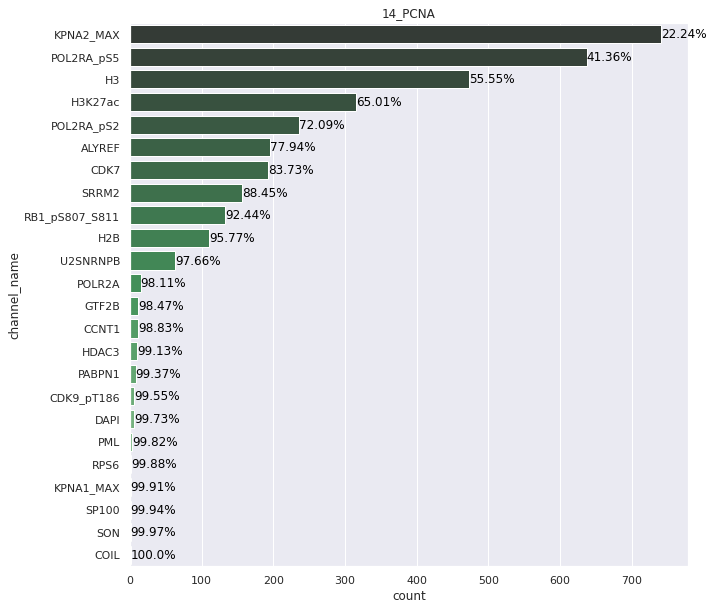

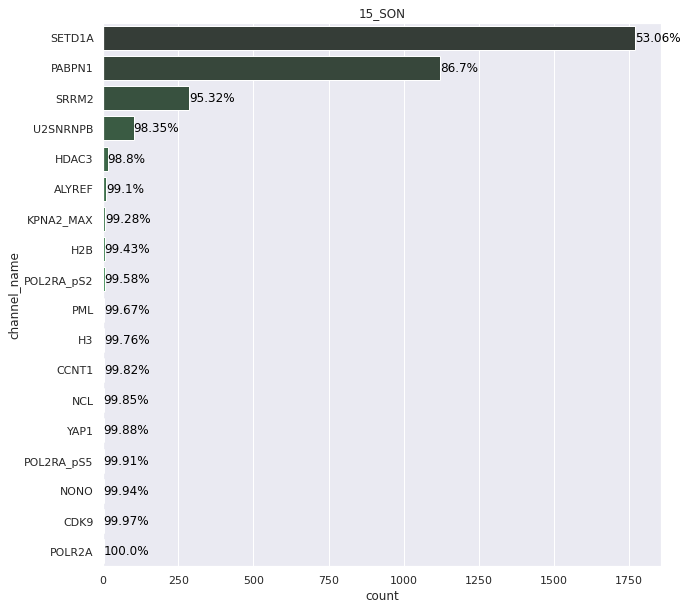

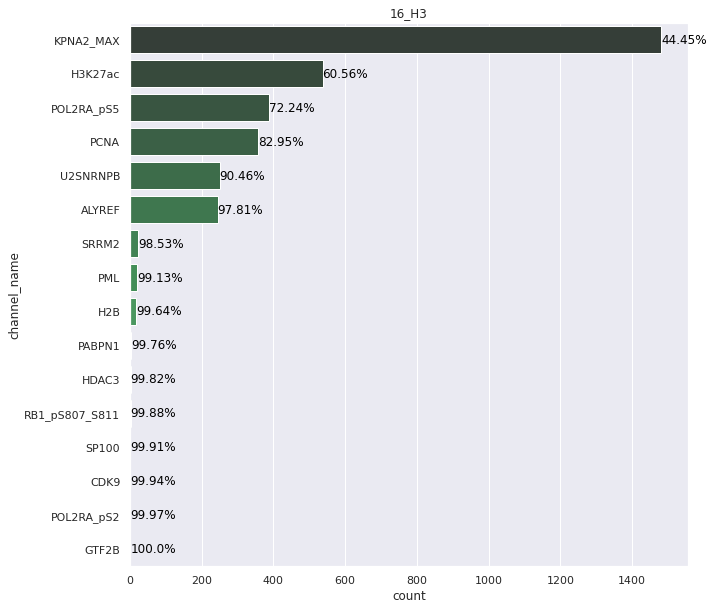

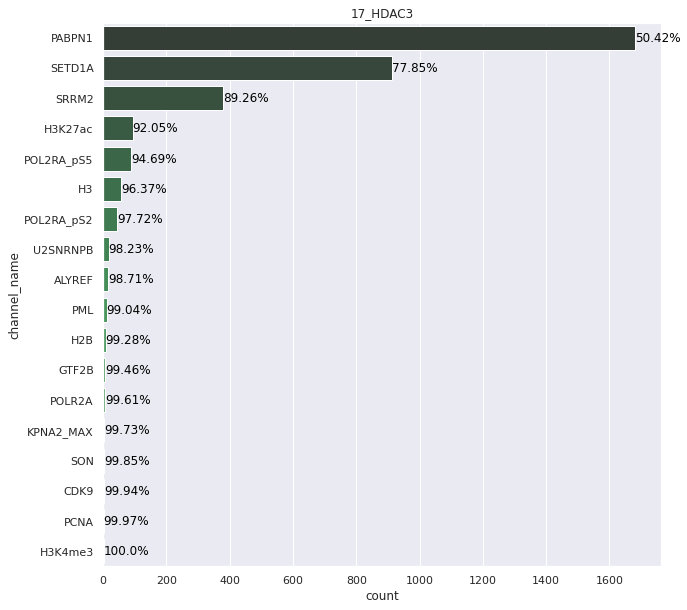

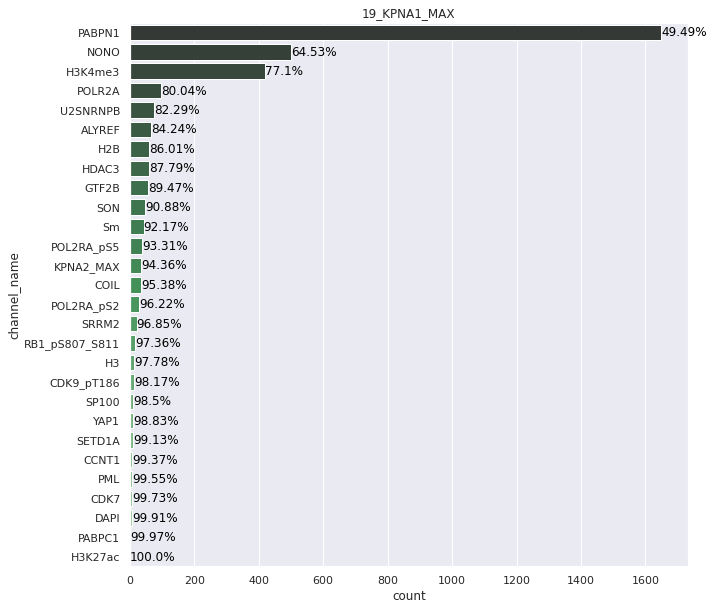

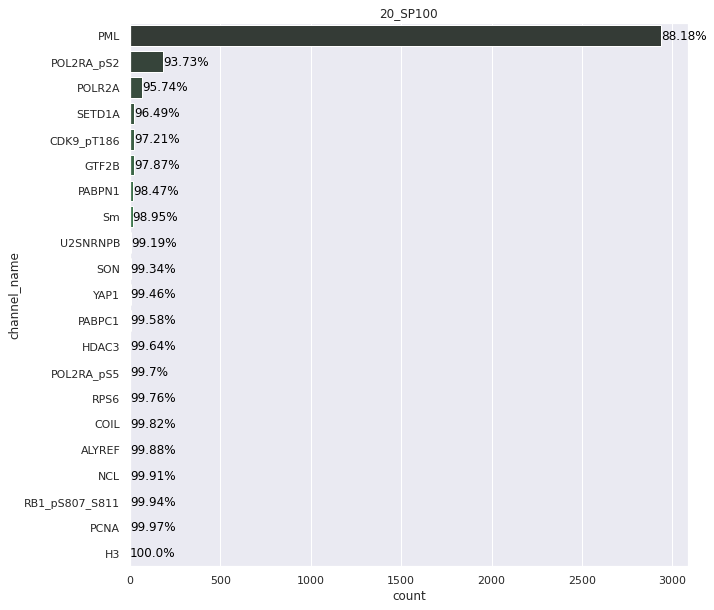

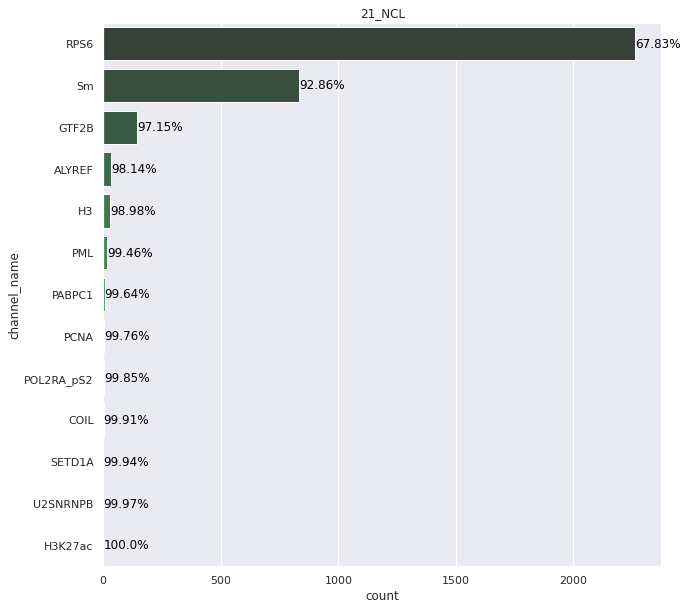

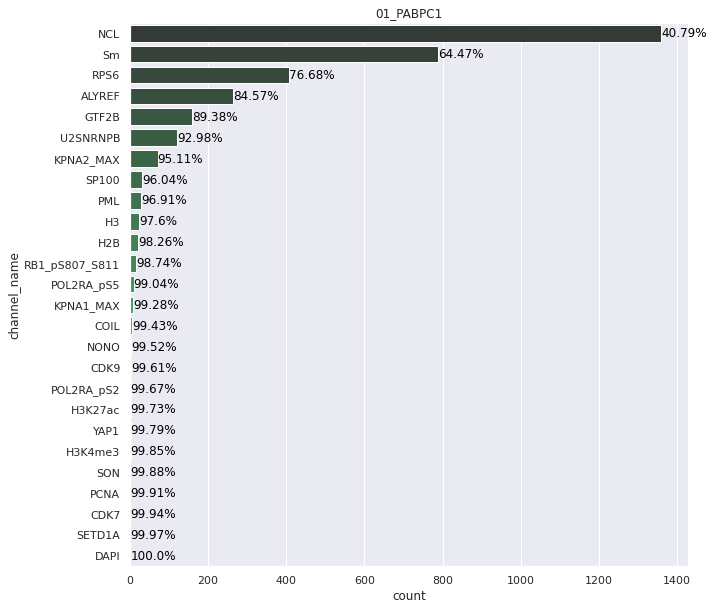

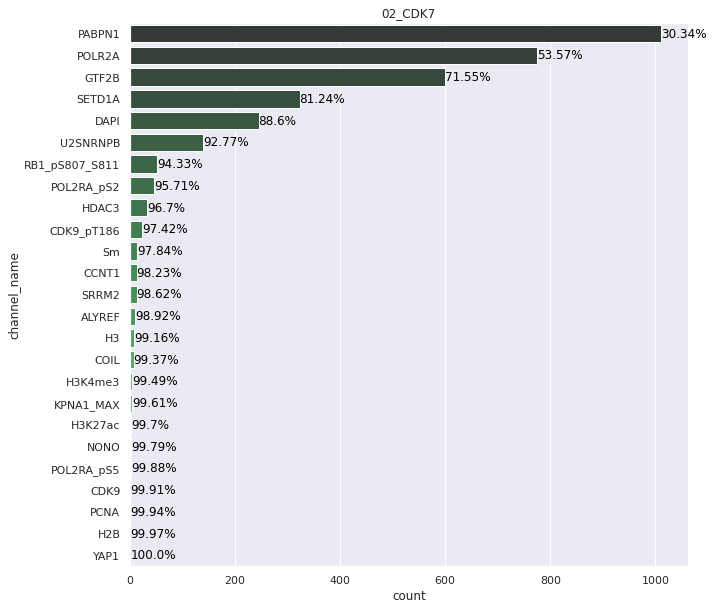

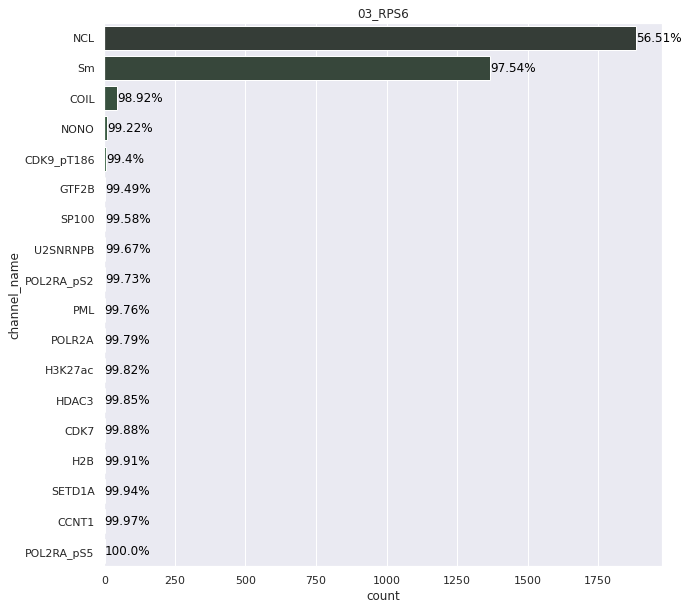

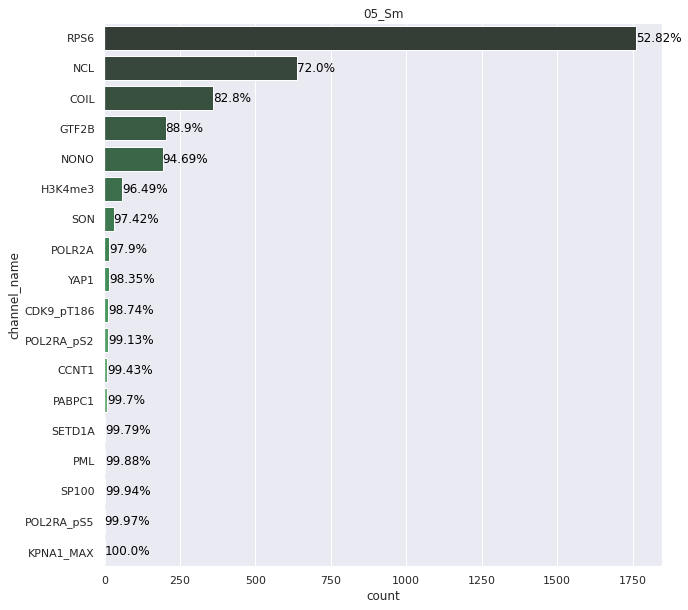

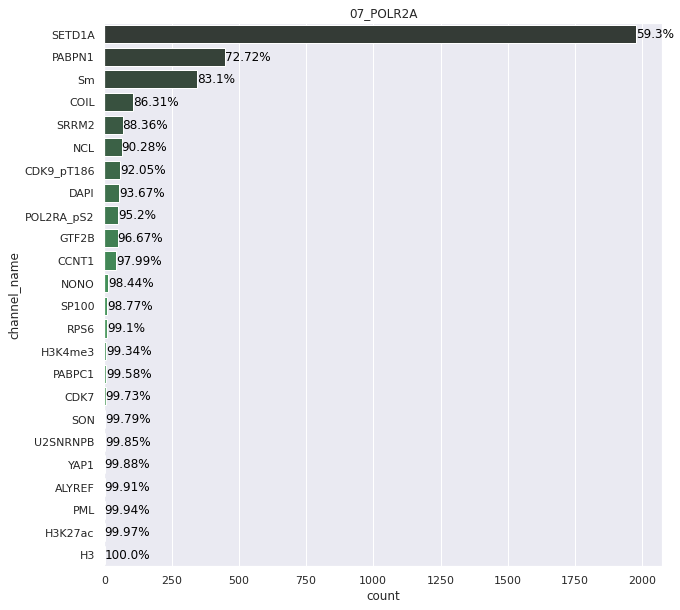

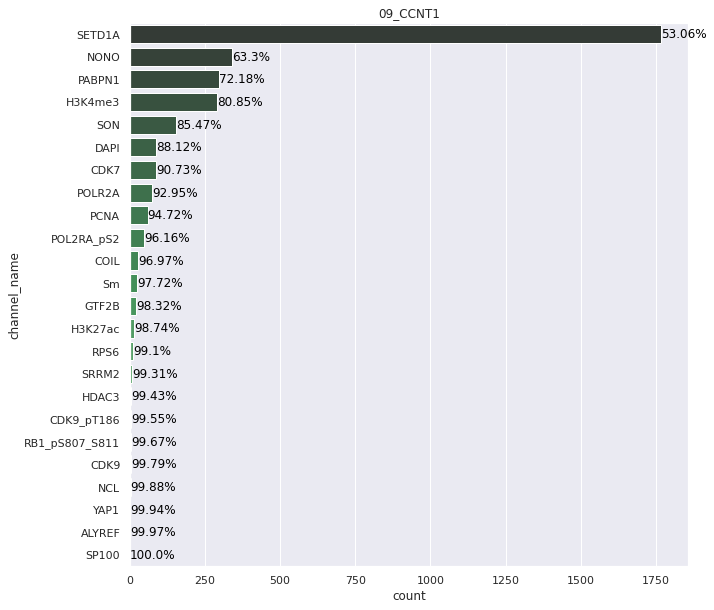

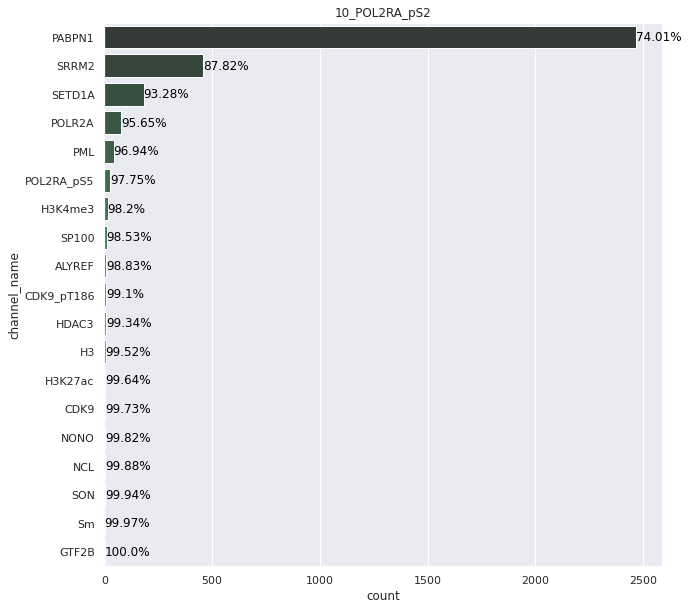

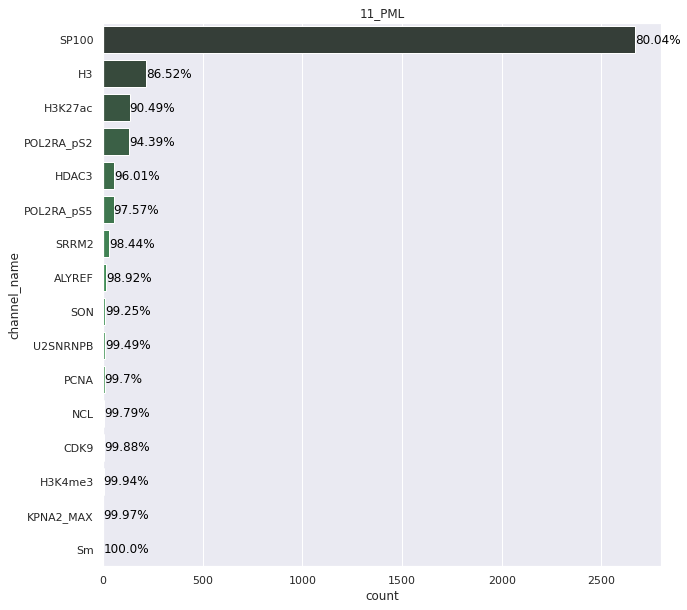

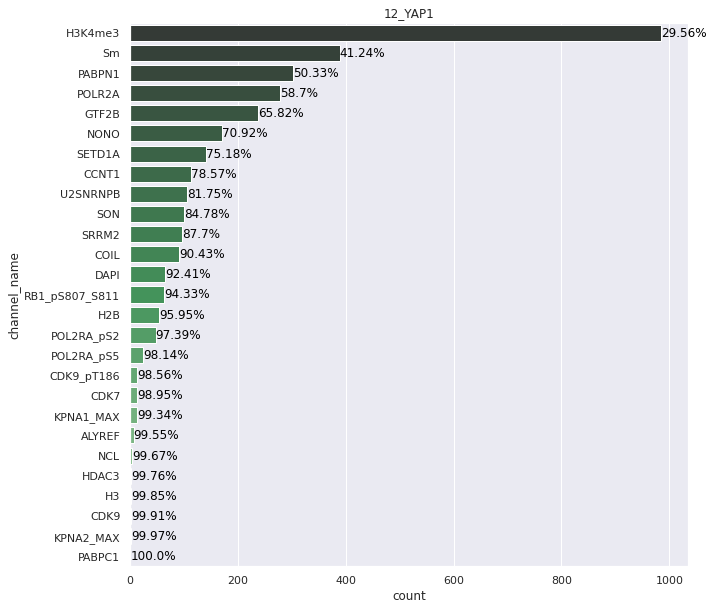

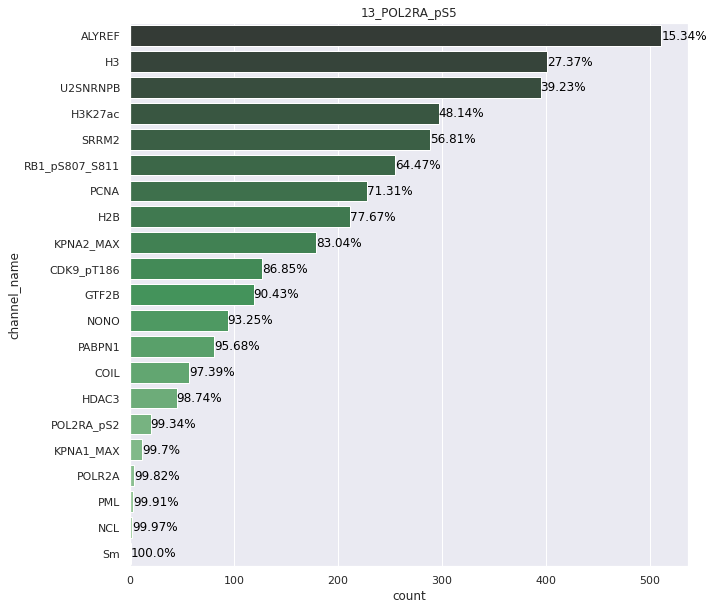

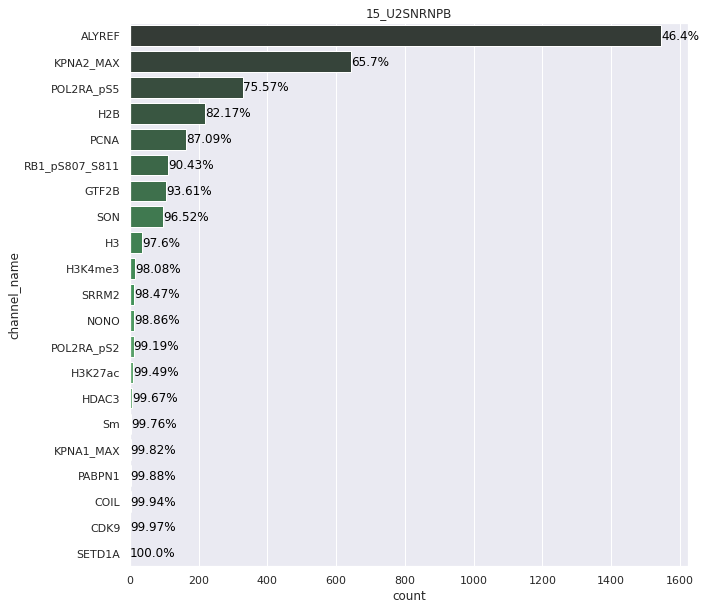

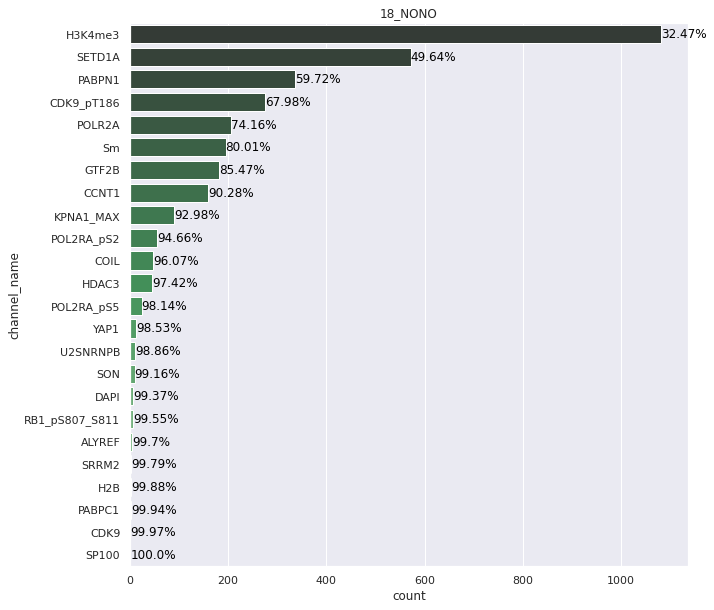

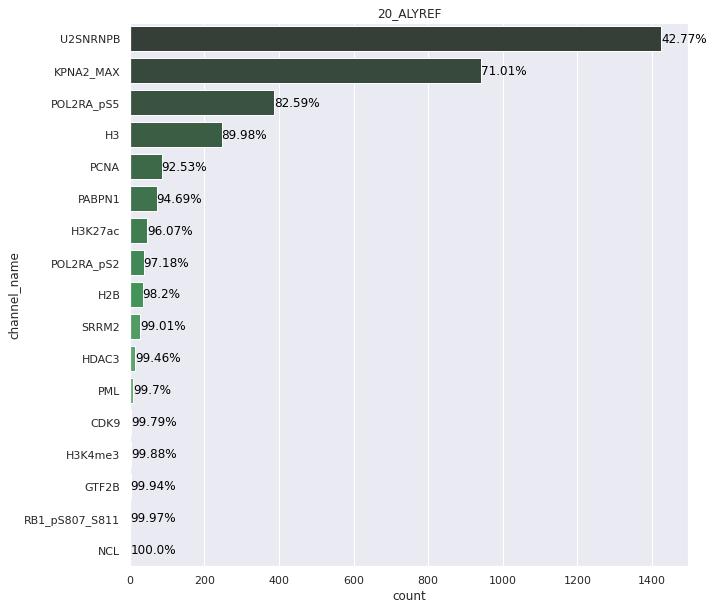

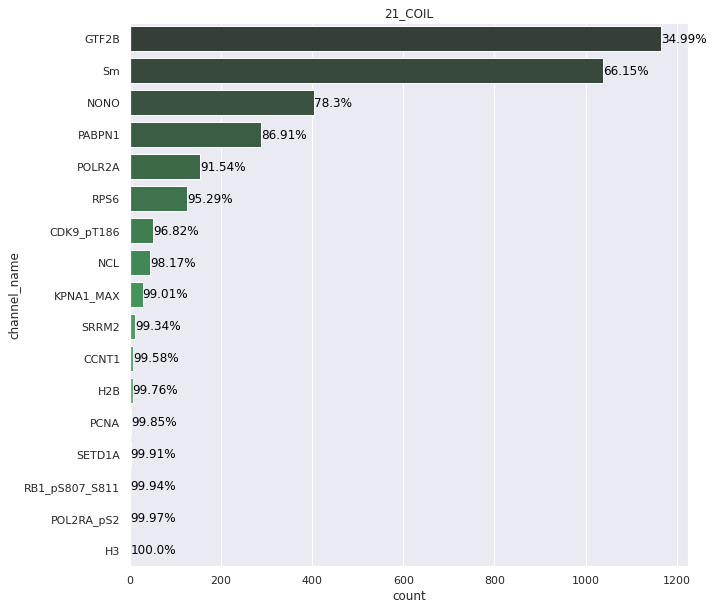

In [164]:
for c in input_channel_names:
    temp_df = sm_to_sm_dist_df[c+'_idx'].copy()
    channel_counts = temp_df.value_counts().reset_index()
    channel_counts.columns = ['TFDS_channel_id', 'count']
    total_counts = channel_counts['count'].sum()
    channel_counts['cum_percent'] = channel_counts['count'].cumsum() / total_counts
    channel_counts = channel_counts.merge(channels_df[['TFDS_channel_id', 'channel_name']],
                             left_on='TFDS_channel_id',
                             right_on='TFDS_channel_id',
                             how='left'
                            )
    plt.figure(figsize=(10,10))
    pal = sns.color_palette("Greens_d", channel_counts.shape[0])
    g = sns.barplot(data=channel_counts,
                    y='channel_name',
                    x='count',
                    palette=np.array(pal[::-1]),
                    orient="h"
                   )
    plt.title(c)
    # add per cents
    for _, row in channel_counts.iterrows():
        g.text(row['count'], row.name, str(round(100 * row.cum_percent,2))+'%', color='black', ha="left", va="center")
